In [32]:
# Step 1: Summarizing all csv files that are automatically and manually filtered.

import os
import pandas as pd
import numpy as np
from pathlib import Path
import logging
from typing import List, Tuple, Dict
from scipy import stats
from scipy import interpolate
from tqdm.auto import tqdm

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class NeuralDataAnalyzer:
    def __init__(self, base_dir: str):
        self.base_dir = Path(base_dir)
        self.baseline_start = -2  # seconds
        self.baseline_end = 0     # seconds

    def get_subfolder_paths(self) -> List[Path]:
        """Get all subfolders ending with 'ms'."""
        try:
            folders = [
                d for d in self.base_dir.iterdir() 
                if d.is_dir() and d.name.endswith('ms')
            ]
            folders.sort(key=lambda x: int(x.name.split('ms')[0]))  # Sort by ms value
            return folders
        except Exception as e:
            logging.error(f"Error accessing directory {self.base_dir}: {e}")
            return []
        
    def find_stim_start(self, df: pd.DataFrame) -> float:
        """Find stimulus start time handling both regular and 0ms cases."""
        if df['Opto Stimulus'].max() > 0:
            # Regular case - find first non-zero stimulus
            stim_start_idx = (df['Opto Stimulus'] > 0).idxmax()
            return df.loc[stim_start_idx, 'Time (s)']
        else:
            # 0ms case - find where time crosses zero
            time_series = df['Time (s)'].values
            zero_crossing_idx = np.where(np.diff(np.signbit(time_series)))[0][0]
            return time_series[zero_crossing_idx]

    def load_and_align_data(self, csv_path: Path) -> pd.DataFrame:
        """Load and align a single CSV file."""
        try:
            df = pd.read_csv(csv_path)
            logging.info(f"Loaded {csv_path.name} with shape {df.shape}")
            
            # Find stimulus start time
            stim_start_time = self.find_stim_start(df)
            logging.info(f"Found stimulus start at t = {stim_start_time:.4f}s")
            
            # Align time to stimulus onset
            df['Time (s)'] = df['Time (s)'] - stim_start_time
            
            logging.info(f"Time range after alignment: {df['Time (s)'].min():.2f} to {df['Time (s)'].max():.2f}")
            return df
            
        except Exception as e:
            logging.error(f"Error processing {csv_path}: {e}")
            return pd.DataFrame()

    def calculate_baseline_wbf(self, df: pd.DataFrame) -> float:
        """Calculate baseline wingbeat frequency."""
        mask = (df['Time (s)'] >= self.baseline_start) & (df['Time (s)'] < self.baseline_end)
        baseline = df.loc[mask, 'Wingbeat Frequency'].mean()
        logging.info(f"Calculated baseline WBF: {baseline:.2f} Hz")
        return baseline

    def find_common_timepoints(self, dfs: List[pd.DataFrame]) -> np.ndarray:
        """Find common timepoints across all dataframes."""
        # Get all unique timepoints from all dataframes
        all_times = np.unique(np.concatenate([df['Time (s)'].values for df in dfs]))
        
        # Find the common time range
        max_start = max(df['Time (s)'].min() for df in dfs)
        min_end = min(df['Time (s)'].max() for df in dfs)
        
        # Filter timepoints to common range
        common_times = all_times[(all_times >= max_start) & (all_times <= min_end)]
        common_times.sort()
        
        return common_times

    def resample_to_common_timepoints(self, df: pd.DataFrame, common_times: np.ndarray) -> pd.DataFrame:
        """Resample a dataframe to common timepoints."""
        resampled = pd.DataFrame()
        resampled['Time (s)'] = common_times
        
        for col in df.columns:
            if col == 'Time (s)':
                continue
            elif col in ['Spike Count', 'Opto Stimulus']:
                # Use nearest neighbor for discrete variables
                f = interpolate.interp1d(df['Time (s)'], df[col], kind='nearest',
                                       bounds_error=False, fill_value=0)
            else:
                # Use linear interpolation for continuous variables
                f = interpolate.interp1d(df['Time (s)'], df[col], kind='linear',
                                       bounds_error=False, fill_value=np.nan)
            resampled[col] = f(common_times)
            
        return resampled

    def process_single_folder(self, folder_path: Path) -> pd.DataFrame:
        """Process all CSV files in a single folder."""
        csv_files = list(folder_path.glob('*.csv'))
        if not csv_files:
            logging.warning(f"No CSV files found in {folder_path}")
            return pd.DataFrame()
            
        # Store all aligned dataframes
        aligned_dfs = []
        
        # Process each CSV file
        for csv_file in tqdm(csv_files, desc=f"Processing {folder_path.name}", leave=False):
            if 'summary' in csv_file.name:  # Skip summary files
                continue
                
            df = self.load_and_align_data(csv_file)
            if df.empty:
                continue
                
            # Calculate and subtract baseline WBF
            baseline = self.calculate_baseline_wbf(df)
            df['Delta Wingbeat Frequency'] = df['Wingbeat Frequency'] - baseline
            
            logging.info(f"File: {csv_file.name}")
            logging.info(f"Raw WBF range: {df['Wingbeat Frequency'].min():.2f} to {df['Wingbeat Frequency'].max():.2f}")
            logging.info(f"Delta WBF range: {df['Delta Wingbeat Frequency'].min():.2f} to {df['Delta Wingbeat Frequency'].max():.2f}")
            
            # Rename Spike Count to include trial number
            trial_num = len(aligned_dfs) + 1
            df = df.rename(columns={'Spike Count': f'Spike Count Trial {trial_num}'})
            
            aligned_dfs.append(df)
        
        if not aligned_dfs:
            logging.warning(f"No valid data found in {folder_path}")
            return pd.DataFrame()
        
        # Find common timepoints and resample all dataframes
        common_times = self.find_common_timepoints(aligned_dfs)
        resampled_dfs = [self.resample_to_common_timepoints(df, common_times) for df in aligned_dfs]
        
        # Create summary dataframe
        summary_df = pd.DataFrame()
        summary_df['Time (s)'] = common_times
        
        # Calculate means and SEMs
        metrics = ['Delta Wingbeat Frequency', 'Wing Beat Amplitude', 'Spike Rate']
        for metric in metrics:
            values = np.array([df[metric].values for df in resampled_dfs])
            mean = np.nanmean(values, axis=0)
            sem = stats.sem(values, axis=0, nan_policy='omit')
            
            summary_df[f'Mean {metric}'] = mean
            summary_df[f'SEM {metric}'] = sem
            
            logging.info(f"{metric} summary stats:")
            logging.info(f"Mean range: {np.nanmin(mean):.2f} to {np.nanmax(mean):.2f}")
        
        # Add individual trial spike counts
        for i, df in enumerate(resampled_dfs, 1):
            summary_df[f'Spike Count Trial {i}'] = df[f'Spike Count Trial {i}']
        
        # Add Opto Stimulus (take from first trial)
        summary_df['Opto Stimulus'] = resampled_dfs[0]['Opto Stimulus']
        
        return summary_df

    def process_all_folders(self):
        subfolders = self.get_subfolder_paths()
    
        for folder in tqdm(subfolders, desc="Processing folders", unit="folder"):
            summary_df = self.process_single_folder(folder)
        
            if not summary_df.empty:
                # Save in main directory instead of subfolder
                output_path = self.base_dir.parent / f'summary_{folder.name}.csv'
                summary_df.to_csv(output_path, index=False)
                logging.info(f"Saved summary to: {output_path}")

def main():
    # This is the "output_csv_filtered" folder.
    base_dir = Path('/Users/camellyc/Library/CloudStorage/GoogleDrive-yichen@tuthill.casa/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Yichen/Spiracle/Spiracle Imaging/EMG_Analysis/3_spSN_ChR/241126_spSN_ChR_EMG_Fly2_Y/output_csv_spikefiltered')
    
    try:
        analyzer = NeuralDataAnalyzer(base_dir)
        analyzer.process_all_folders()
        logging.info("Analysis completed successfully")
        
    except Exception as e:
        logging.error(f"Analysis failed: {e}")

if __name__ == "__main__":
    main()

Processing folders:   0%|          | 0/3 [00:00<?, ?folder/s]2024-12-08 09:51:09,271 - INFO - Loaded spSN_ChR_EMG_VT021853_R10G03_4d_F_Fly2_Trial6_0-1000ms_2024_1126_125610_bout3_stim0ms.csv with shape (400000, 10)
2024-12-08 09:51:09,272 - INFO - Found stimulus start at t = -0.0001s
2024-12-08 09:51:09,273 - INFO - Time range after alignment: -5.00 to 15.00
2024-12-08 09:51:09,274 - INFO - Calculated baseline WBF: 185.65 Hz
2024-12-08 09:51:09,275 - INFO - File: spSN_ChR_EMG_VT021853_R10G03_4d_F_Fly2_Trial6_0-1000ms_2024_1126_125610_bout3_stim0ms.csv
2024-12-08 09:51:09,276 - INFO - Raw WBF range: 172.71 to 214.56
2024-12-08 09:51:09,276 - INFO - Delta WBF range: -12.94 to 28.91
2024-12-08 09:51:09,423 - INFO - Loaded spSN_ChR_EMG_VT021853_R10G03_4d_F_Fly2_Trial4_0-1000ms_2024_1126_124644_bout4_stim0ms.csv with shape (400000, 10)
2024-12-08 09:51:09,424 - INFO - Found stimulus start at t = -0.0001s
2024-12-08 09:51:09,425 - INFO - Time range after alignment: -5.00 to 15.00
2024-12-08 

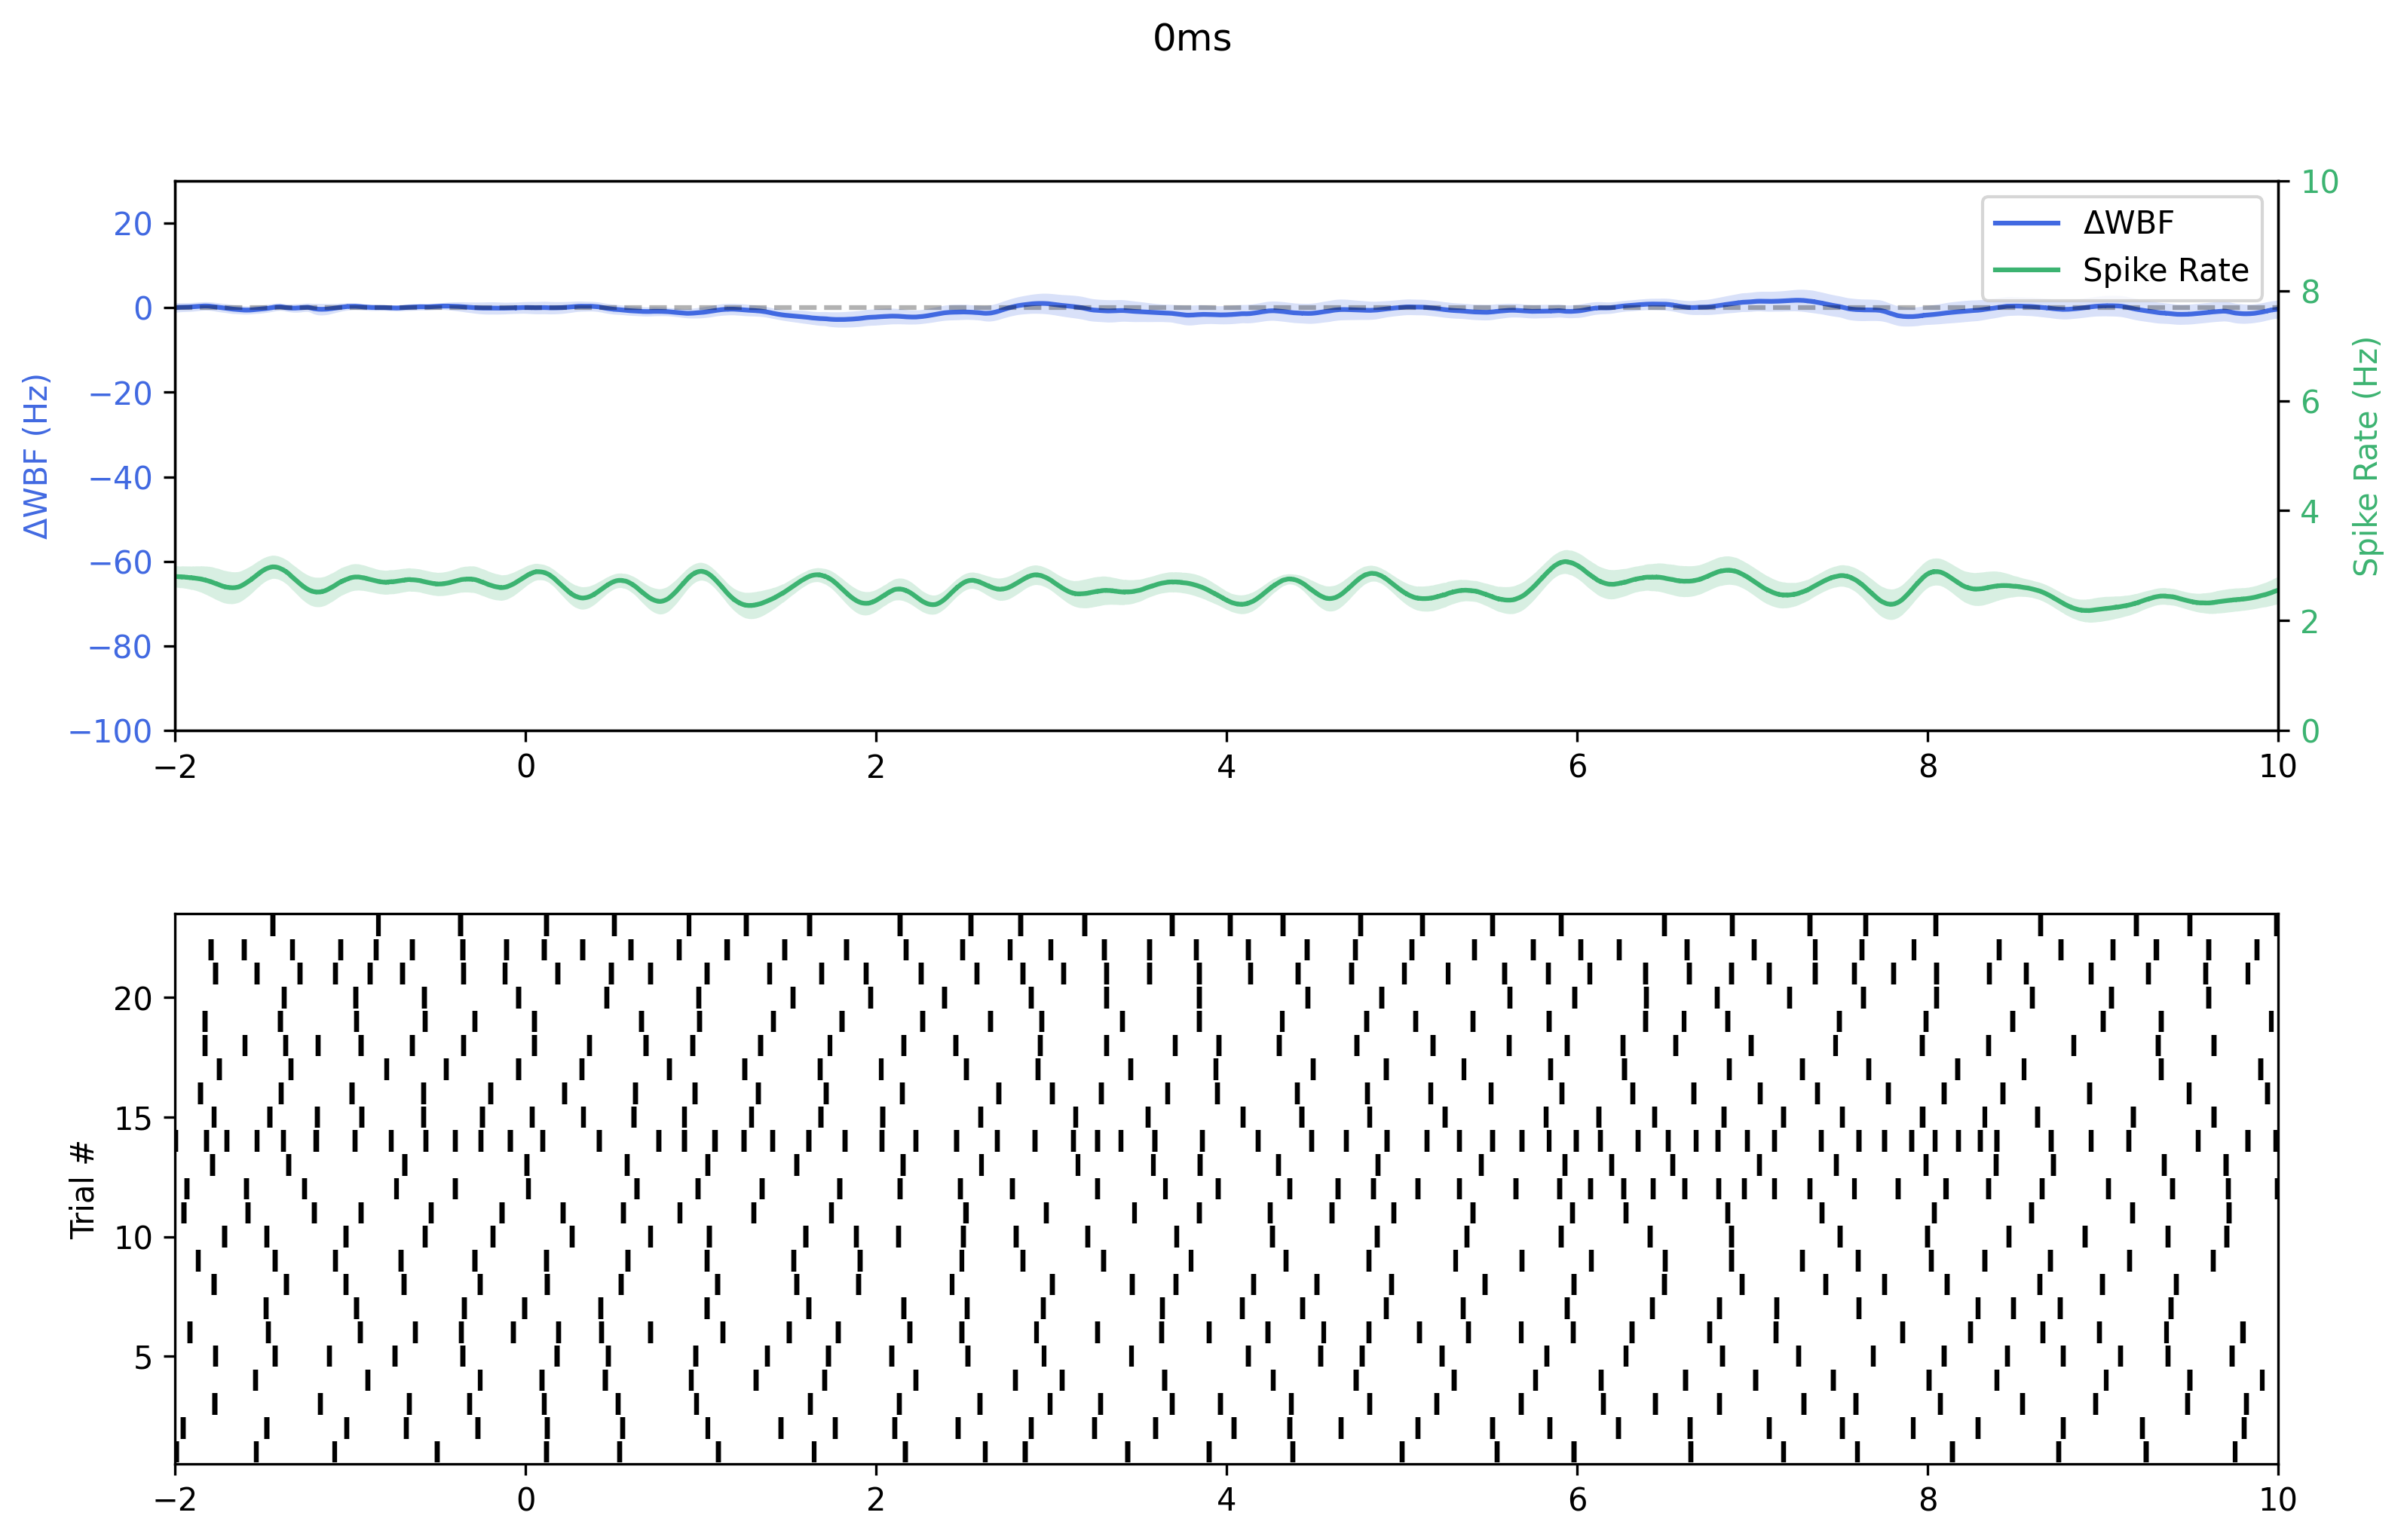

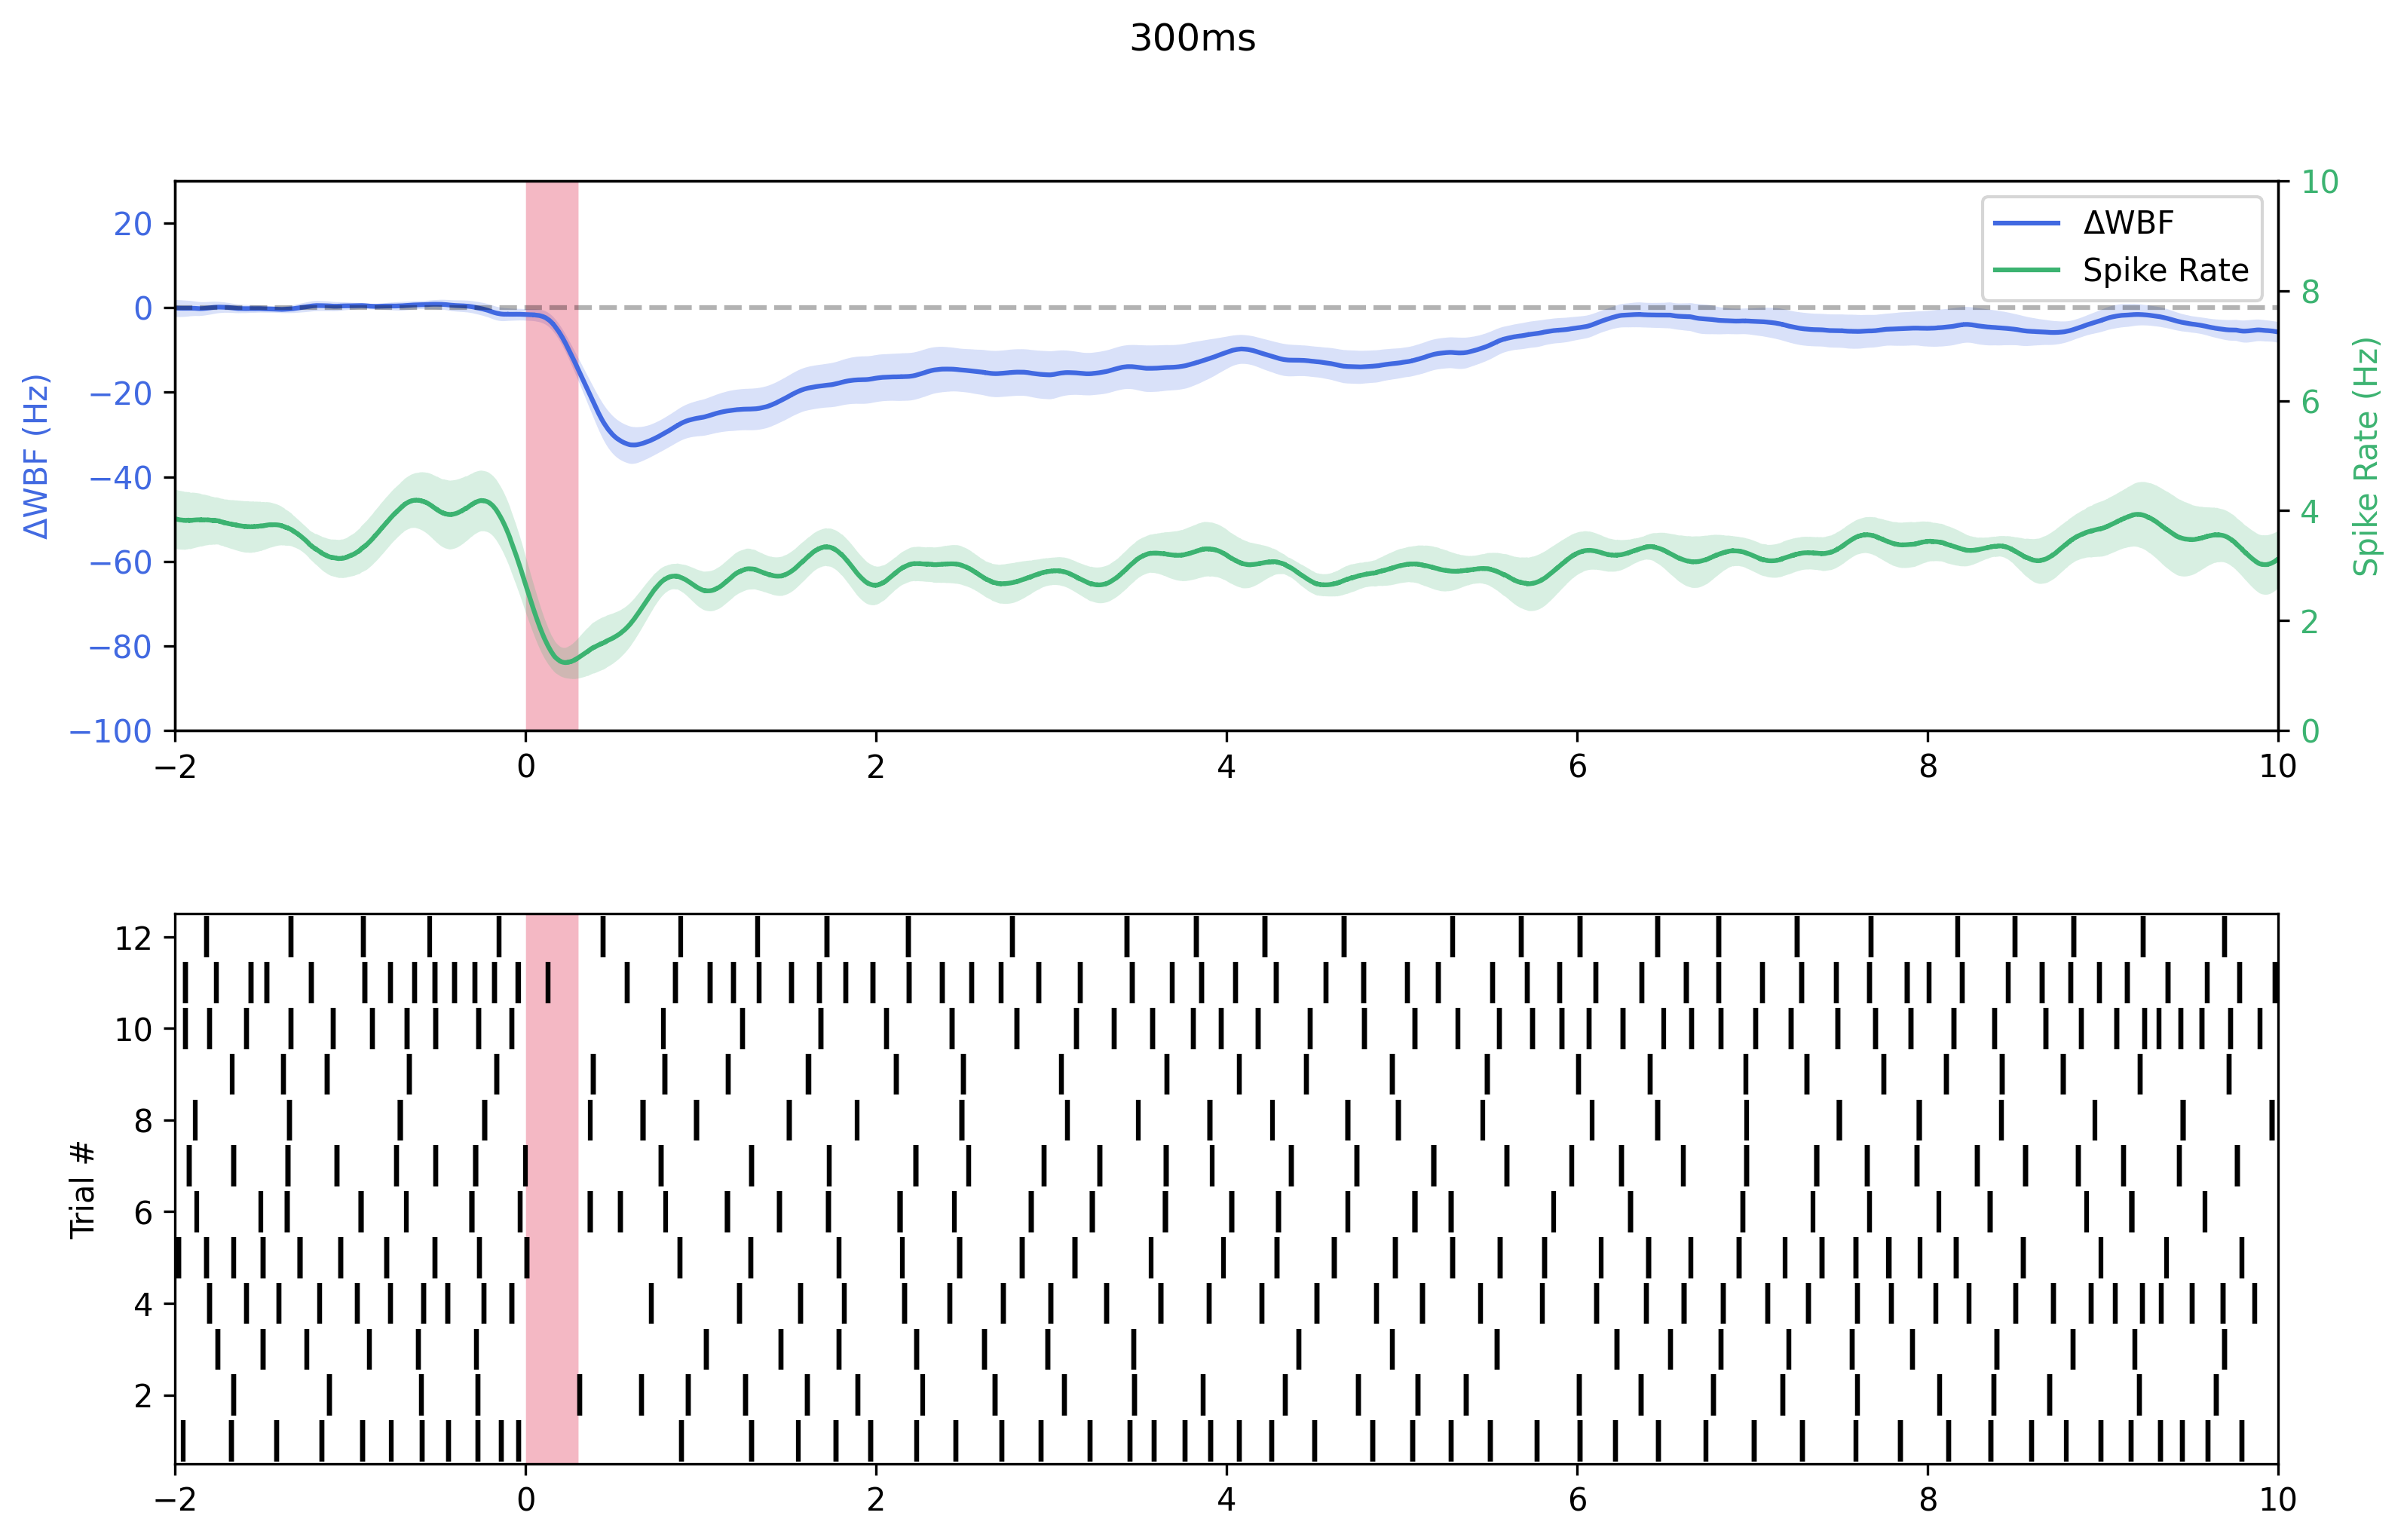

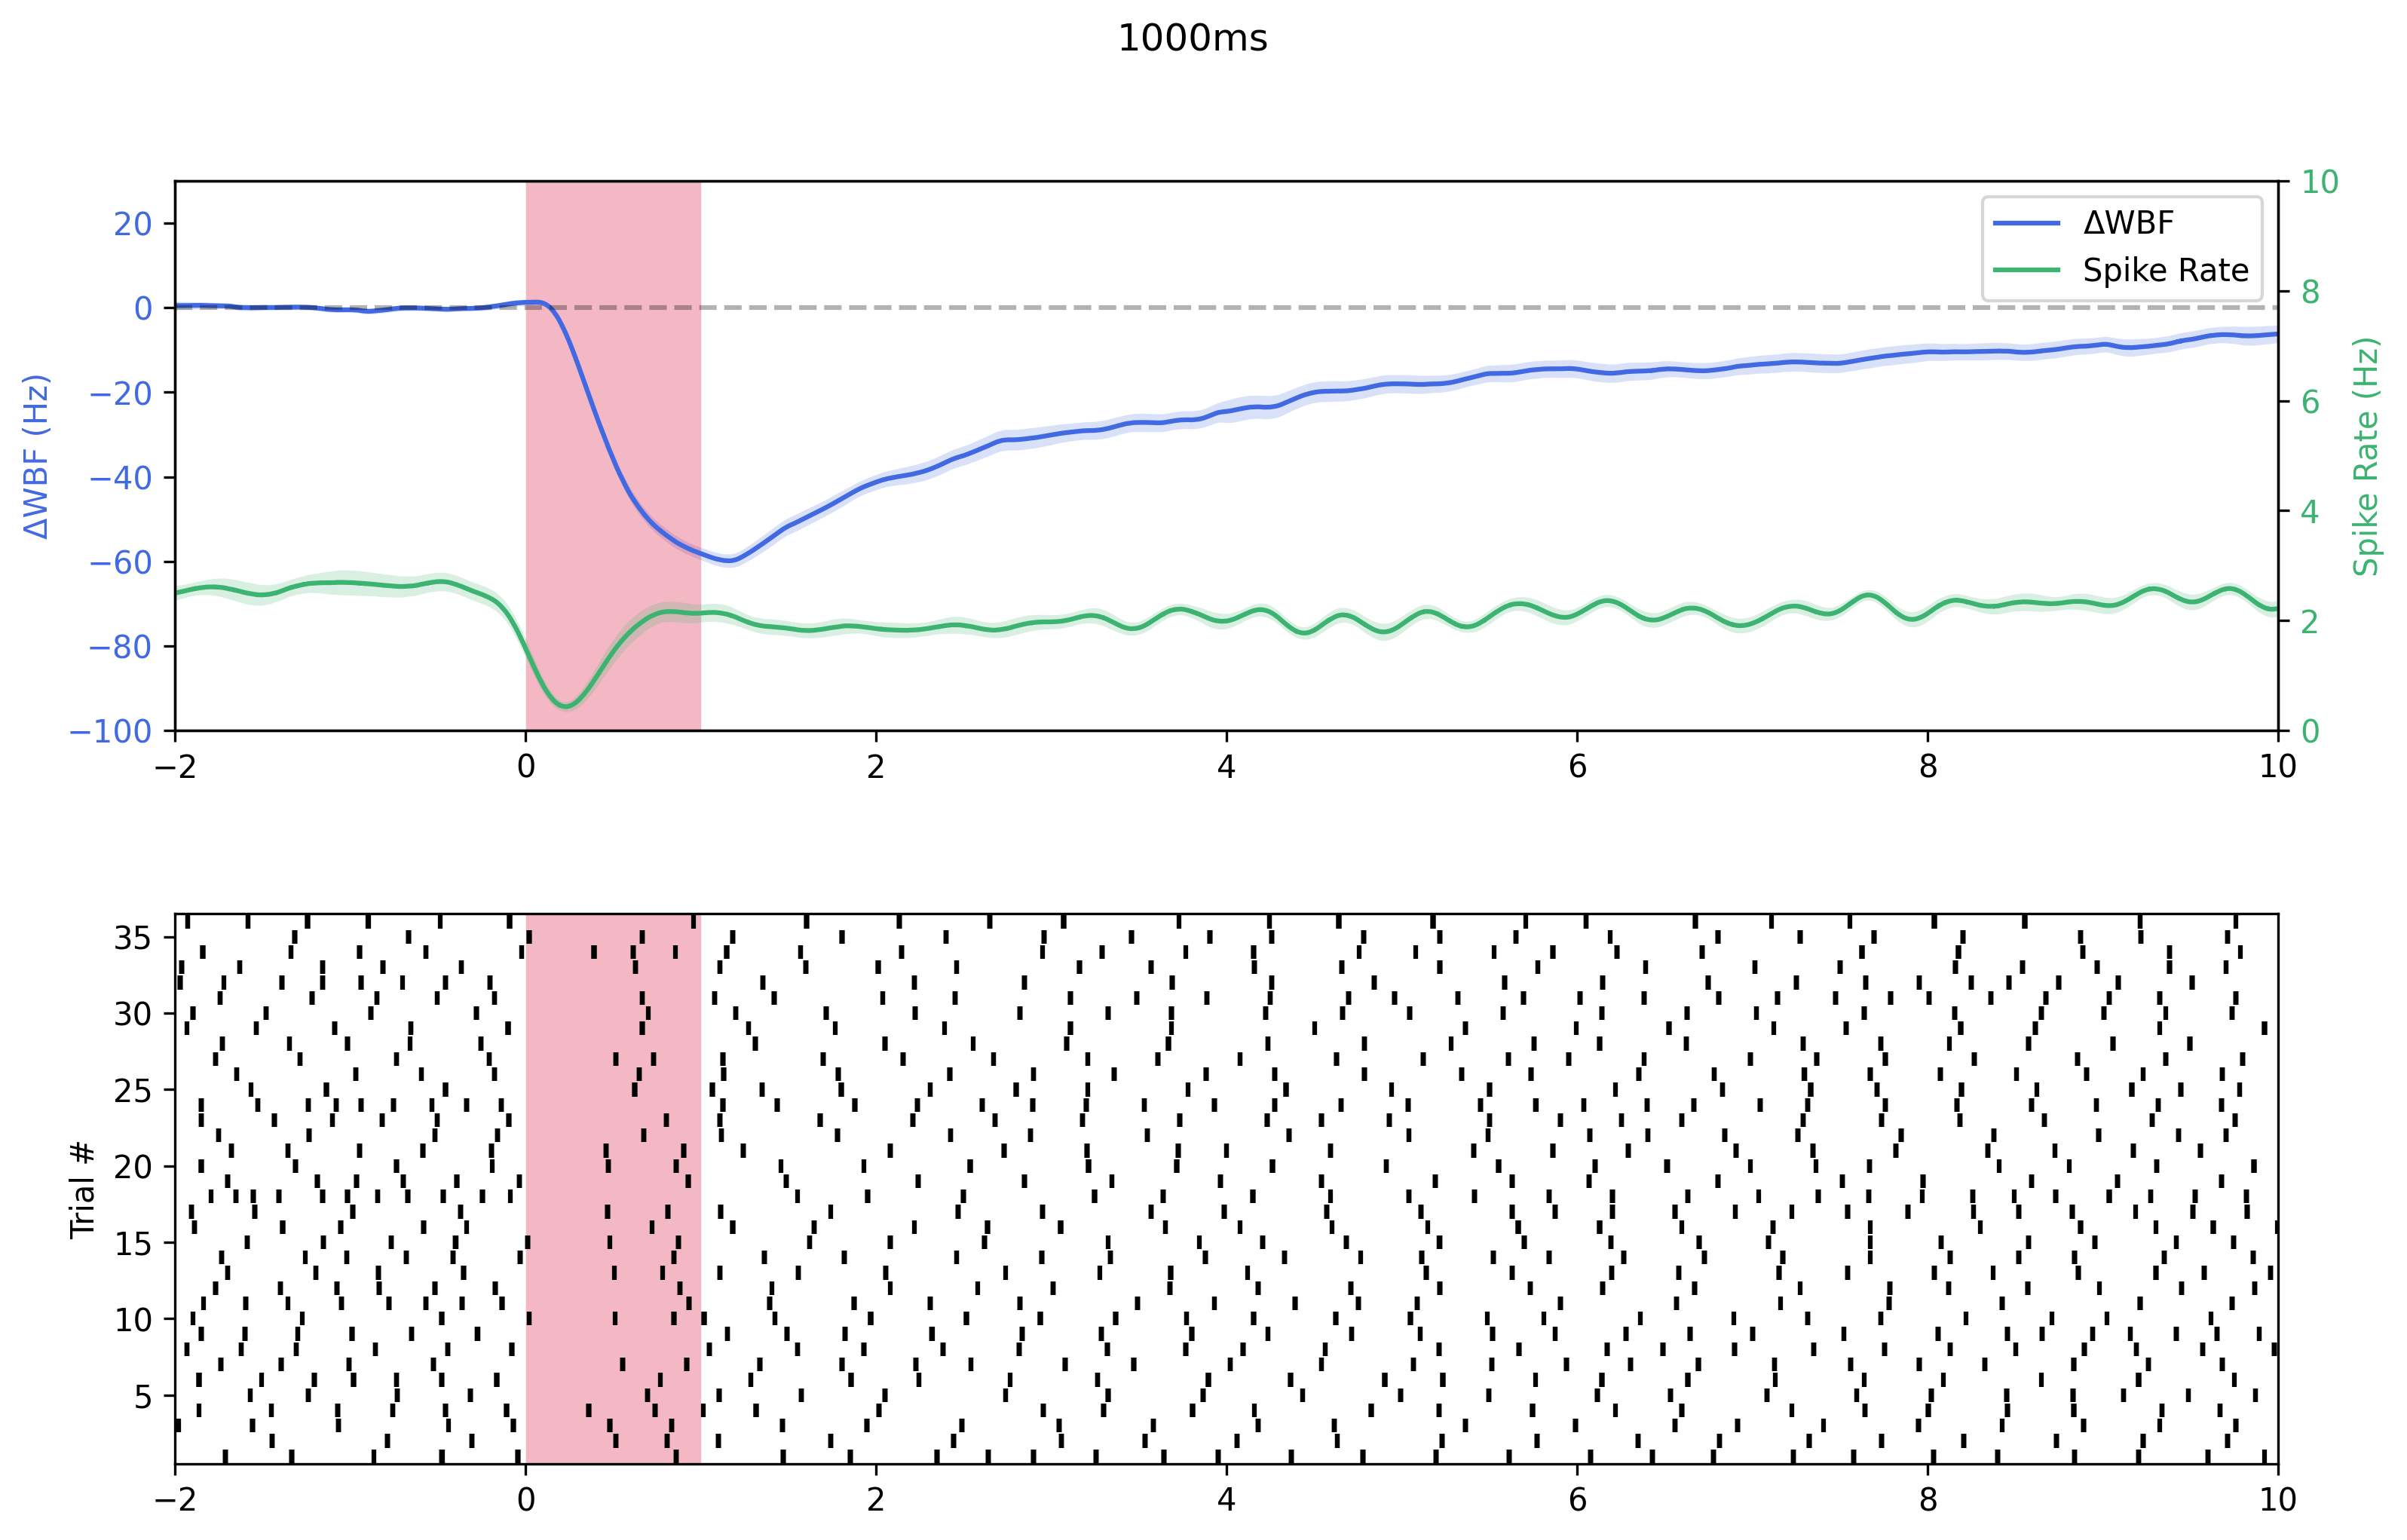

In [33]:
# Step 2: Generate a summary plot for inspection.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

def plot_summary(summary_file: Path, stimcolor, time_window=(-5, 15), save_fig=True) -> None:
    """
    Create a high-resolution two-panel plot for a summary data file.
    """
    # Read data
    df = pd.read_csv(summary_file)
    
    # Get stimulus duration from filename
    stim_duration = summary_file.stem.split('_')[1]  # Gets the 'Xms' part
    
    # Filter data to time window
    mask = (df['Time (s)'] >= time_window[0]) & (df['Time (s)'] <= time_window[1])
    df_window = df[mask].copy()  # Make a copy to avoid SettingWithCopyWarning
    time = df_window['Time (s)'].values  # Convert to numpy array
    
    # Create figure
    fig = plt.figure(figsize=(12, 10), dpi=300)
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 2, 1], hspace=0.4)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # First subplot
    ax1.grid(False)
    
    # WBF on left axis (blue)
    ax1.plot(time, df_window['Mean Delta Wingbeat Frequency'], 
            color='royalblue', label='ΔWBF')
    ax1.fill_between(time,
                    df_window['Mean Delta Wingbeat Frequency'] - df_window['SEM Delta Wingbeat Frequency'],
                    df_window['Mean Delta Wingbeat Frequency'] + df_window['SEM Delta Wingbeat Frequency'],
                    color='royalblue', alpha=0.2,
                    linewidth=0)
    ax1.set_ylabel('ΔWBF (Hz)', color='royalblue')
    ax1.tick_params(axis='y', labelcolor='royalblue')
    ax1.set_ylim(-100, 30)
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)

    # Spike Rate on second twin axis (green)
    ax1_spike = ax1.twinx()
    ax1_spike.grid(False)
    ax1_spike.plot(time, df_window['Mean Spike Rate'], 
                  color='mediumseagreen', label='Spike Rate')
    ax1_spike.fill_between(time,
                          df_window['Mean Spike Rate'] - df_window['SEM Spike Rate'],
                          df_window['Mean Spike Rate'] + df_window['SEM Spike Rate'],
                          color='mediumseagreen', alpha=0.2,
                          linewidth=0)
    ax1_spike.set_ylabel('Spike Rate (Hz)', color='mediumseagreen')
    ax1_spike.tick_params(axis='y', labelcolor='mediumseagreen')
    ax1_spike.set_ylim(0, 10)
    
    # Add stimulus shading
    ymin, ymax = ax1.get_ylim()
    ax1.fill_between(time, ymin, ymax,
                    where=df_window['Opto Stimulus'] > 0,
                    color= stimcolor, alpha=0.3,
                    linewidth=0)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines3, labels3 = ax1_spike.get_legend_handles_labels()
    ax1.legend(lines1 + lines3, 
              labels1 + labels3, 
              loc='upper right')
    
    # Second subplot: Spike raster
    ax2.grid(False)
    spike_columns = [col for col in df_window.columns if 'Spike Count Trial' in col]
    n_trials = len(spike_columns)
    
    # Modified spike detection using eventplot
    for i, col in enumerate(spike_columns):
        # Get spike times using boolean indexing
        spikes = df_window[col].values
        spike_diff = np.diff(spikes)
        spike_indices = np.where(spike_diff > 0)[0]
        spike_times = time[spike_indices]
        
        # Use eventplot instead of scatter
        ax2.eventplot(spike_times, 
                     lineoffsets=i+1,  # Center the line at trial number
                     linelengths=0.9,  # Length of the vertical line
                     color='black')
    
    # Add stimulus shading
    ax2.fill_between(time, 0, n_trials + 1,
                    where=df_window['Opto Stimulus'] > 0,
                    color= stimcolor, alpha=0.3,
                    linewidth=0)
    
    ax2.set_ylim(0.5, n_trials + 0.5)
    ax2.set_ylabel('Trial #')
    
    # Set x-axis limits for all subplots
    for ax in [ax1, ax2]:
        ax.set_xlim(time_window)
    
    # Add title
    fig.suptitle(f"{stim_duration}", y=0.95)
    
    if save_fig:
        output_path = summary_file.parent / f'visualization_{stim_duration}.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# This is the xxx_Fly1_Y folder
base_folder = Path('/Users/camellyc/Library/CloudStorage/GoogleDrive-yichen@tuthill.casa/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Yichen/Spiracle/Spiracle Imaging/EMG_Analysis/3_spSN_ChR/241126_spSN_ChR_EMG_Fly2_Y')

# Plot all summary files directly from the base folder
# Sort files by stimulus duration numerically
summary_files = sorted(
    base_folder.glob('summary_*ms.csv'),
    key=lambda x: int(x.stem.split('_')[1].rstrip('ms'))
)

for summary_file in summary_files:
    plot_summary(summary_file, 'crimson', time_window=(-2, 10))

Found 7 fly folders

Processing 0ms (found in 7 animals)


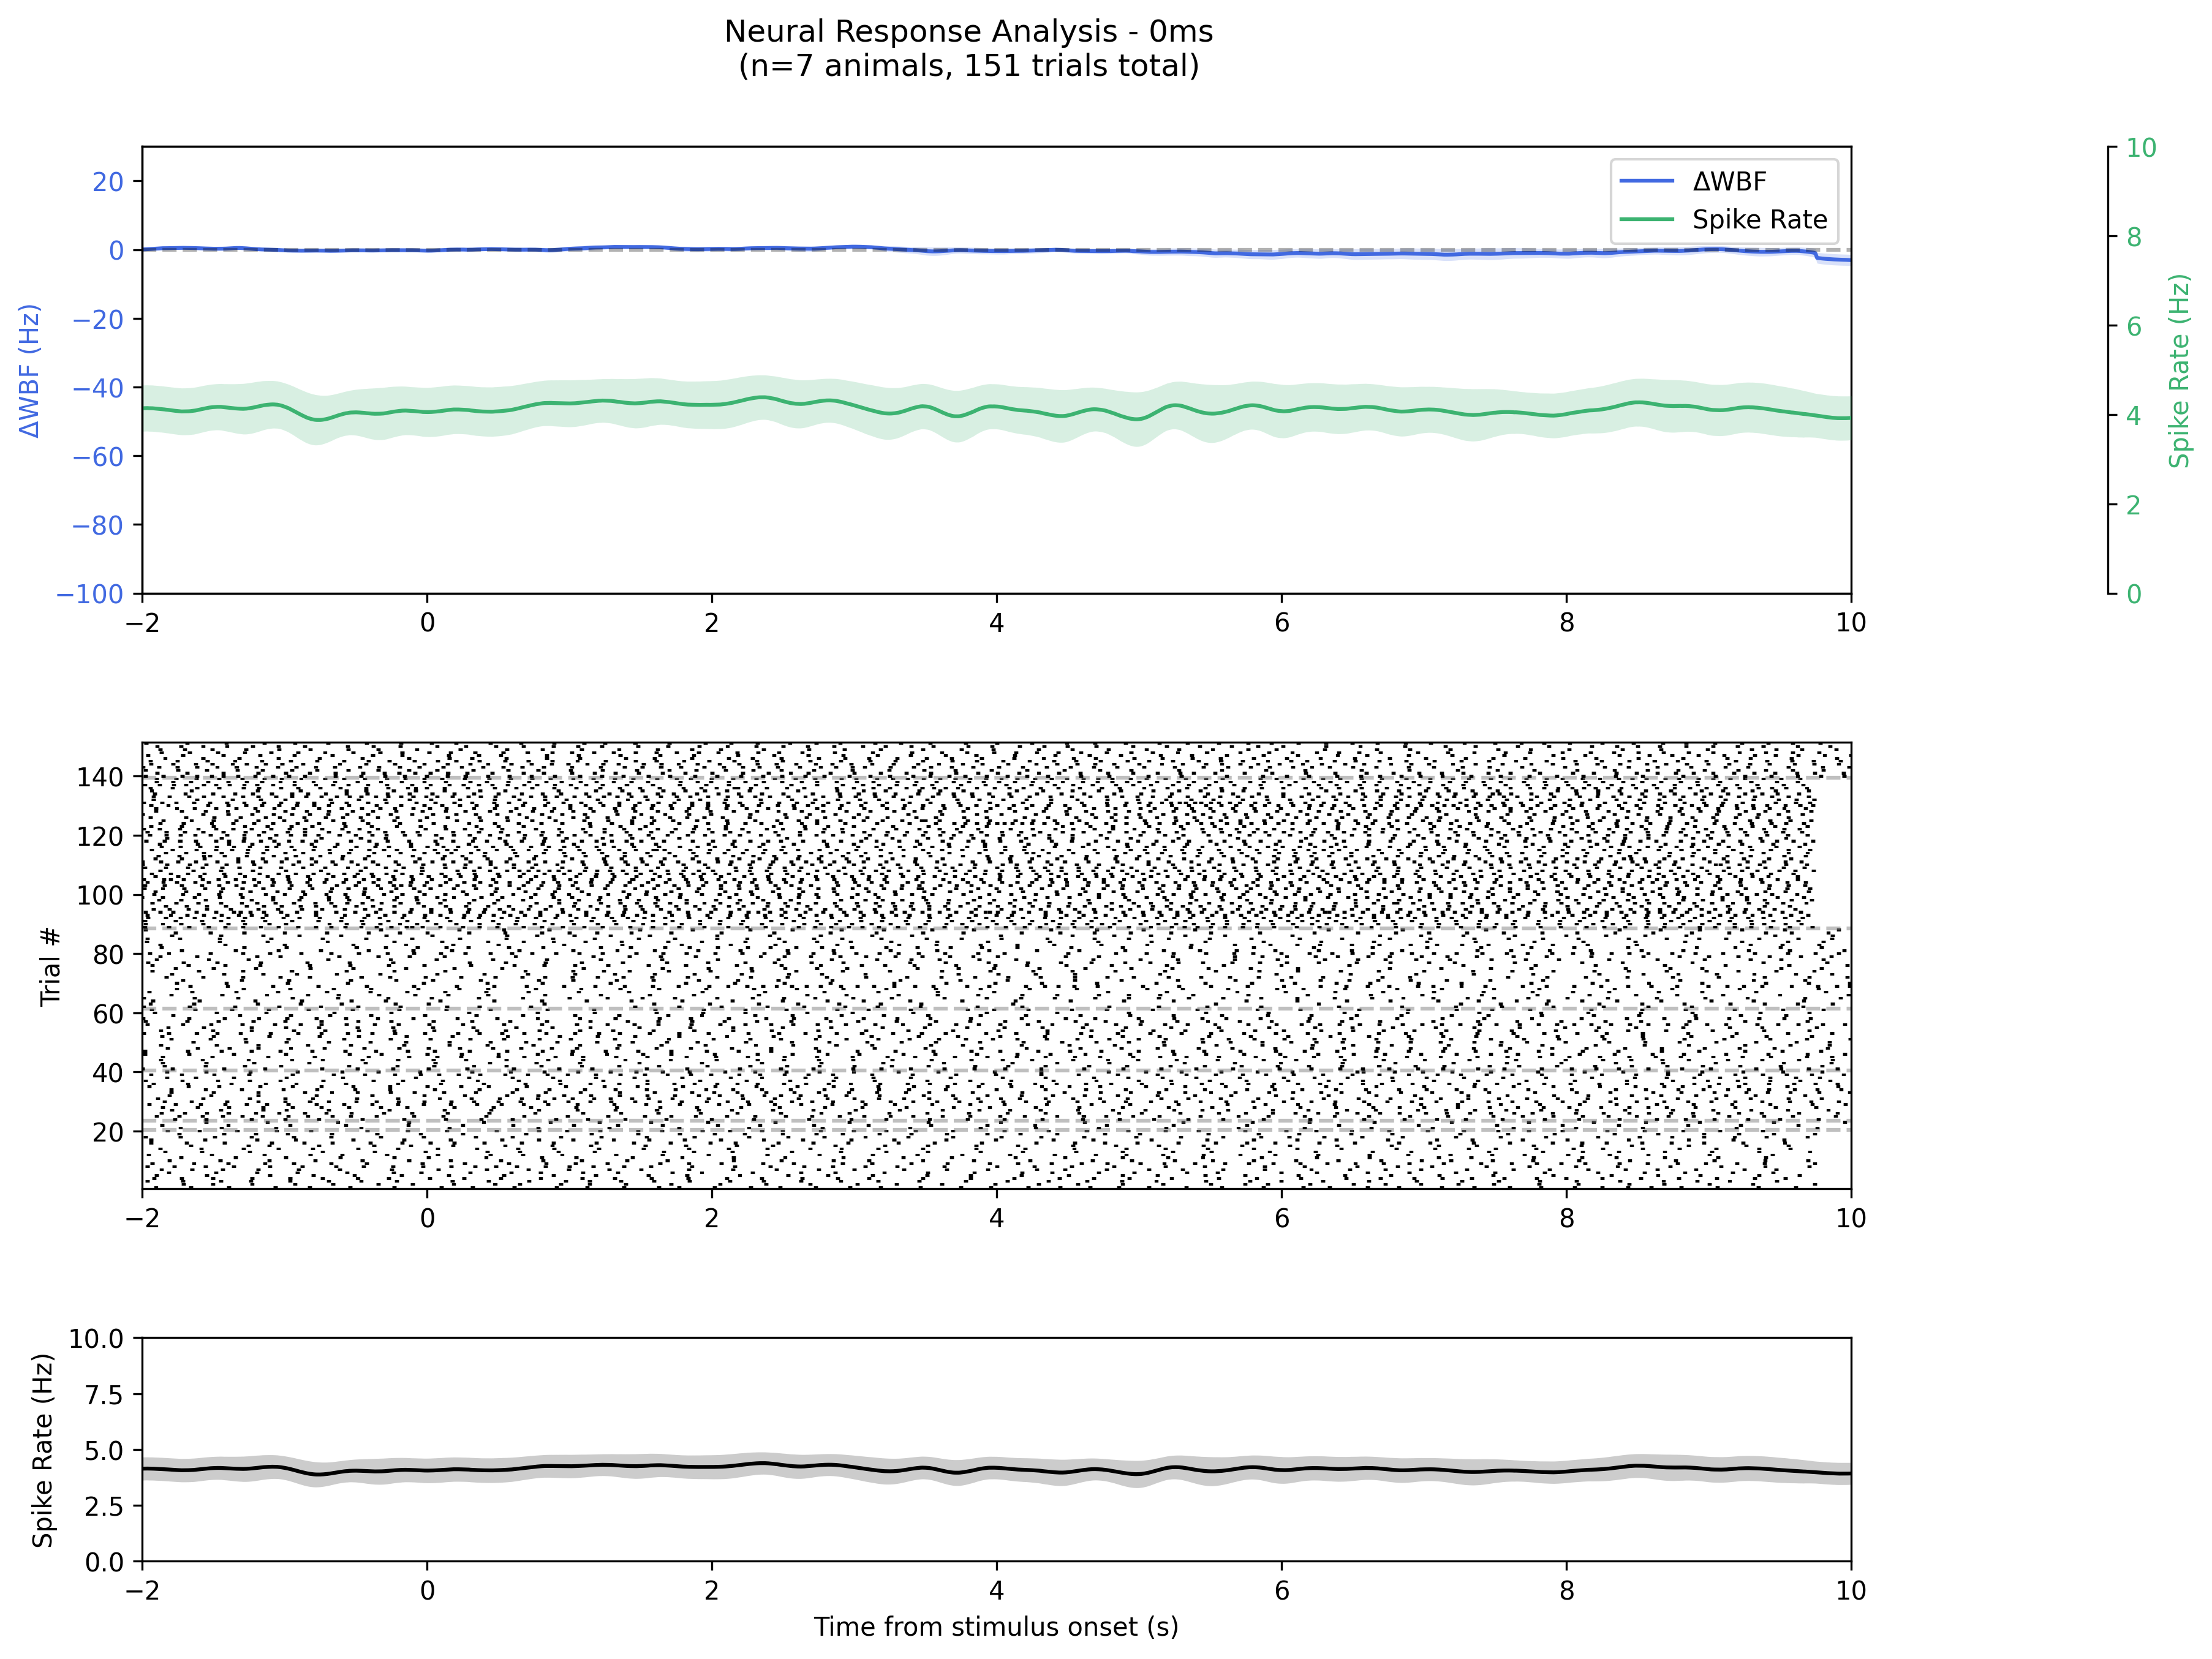


Processing 100ms (found in 2 animals)


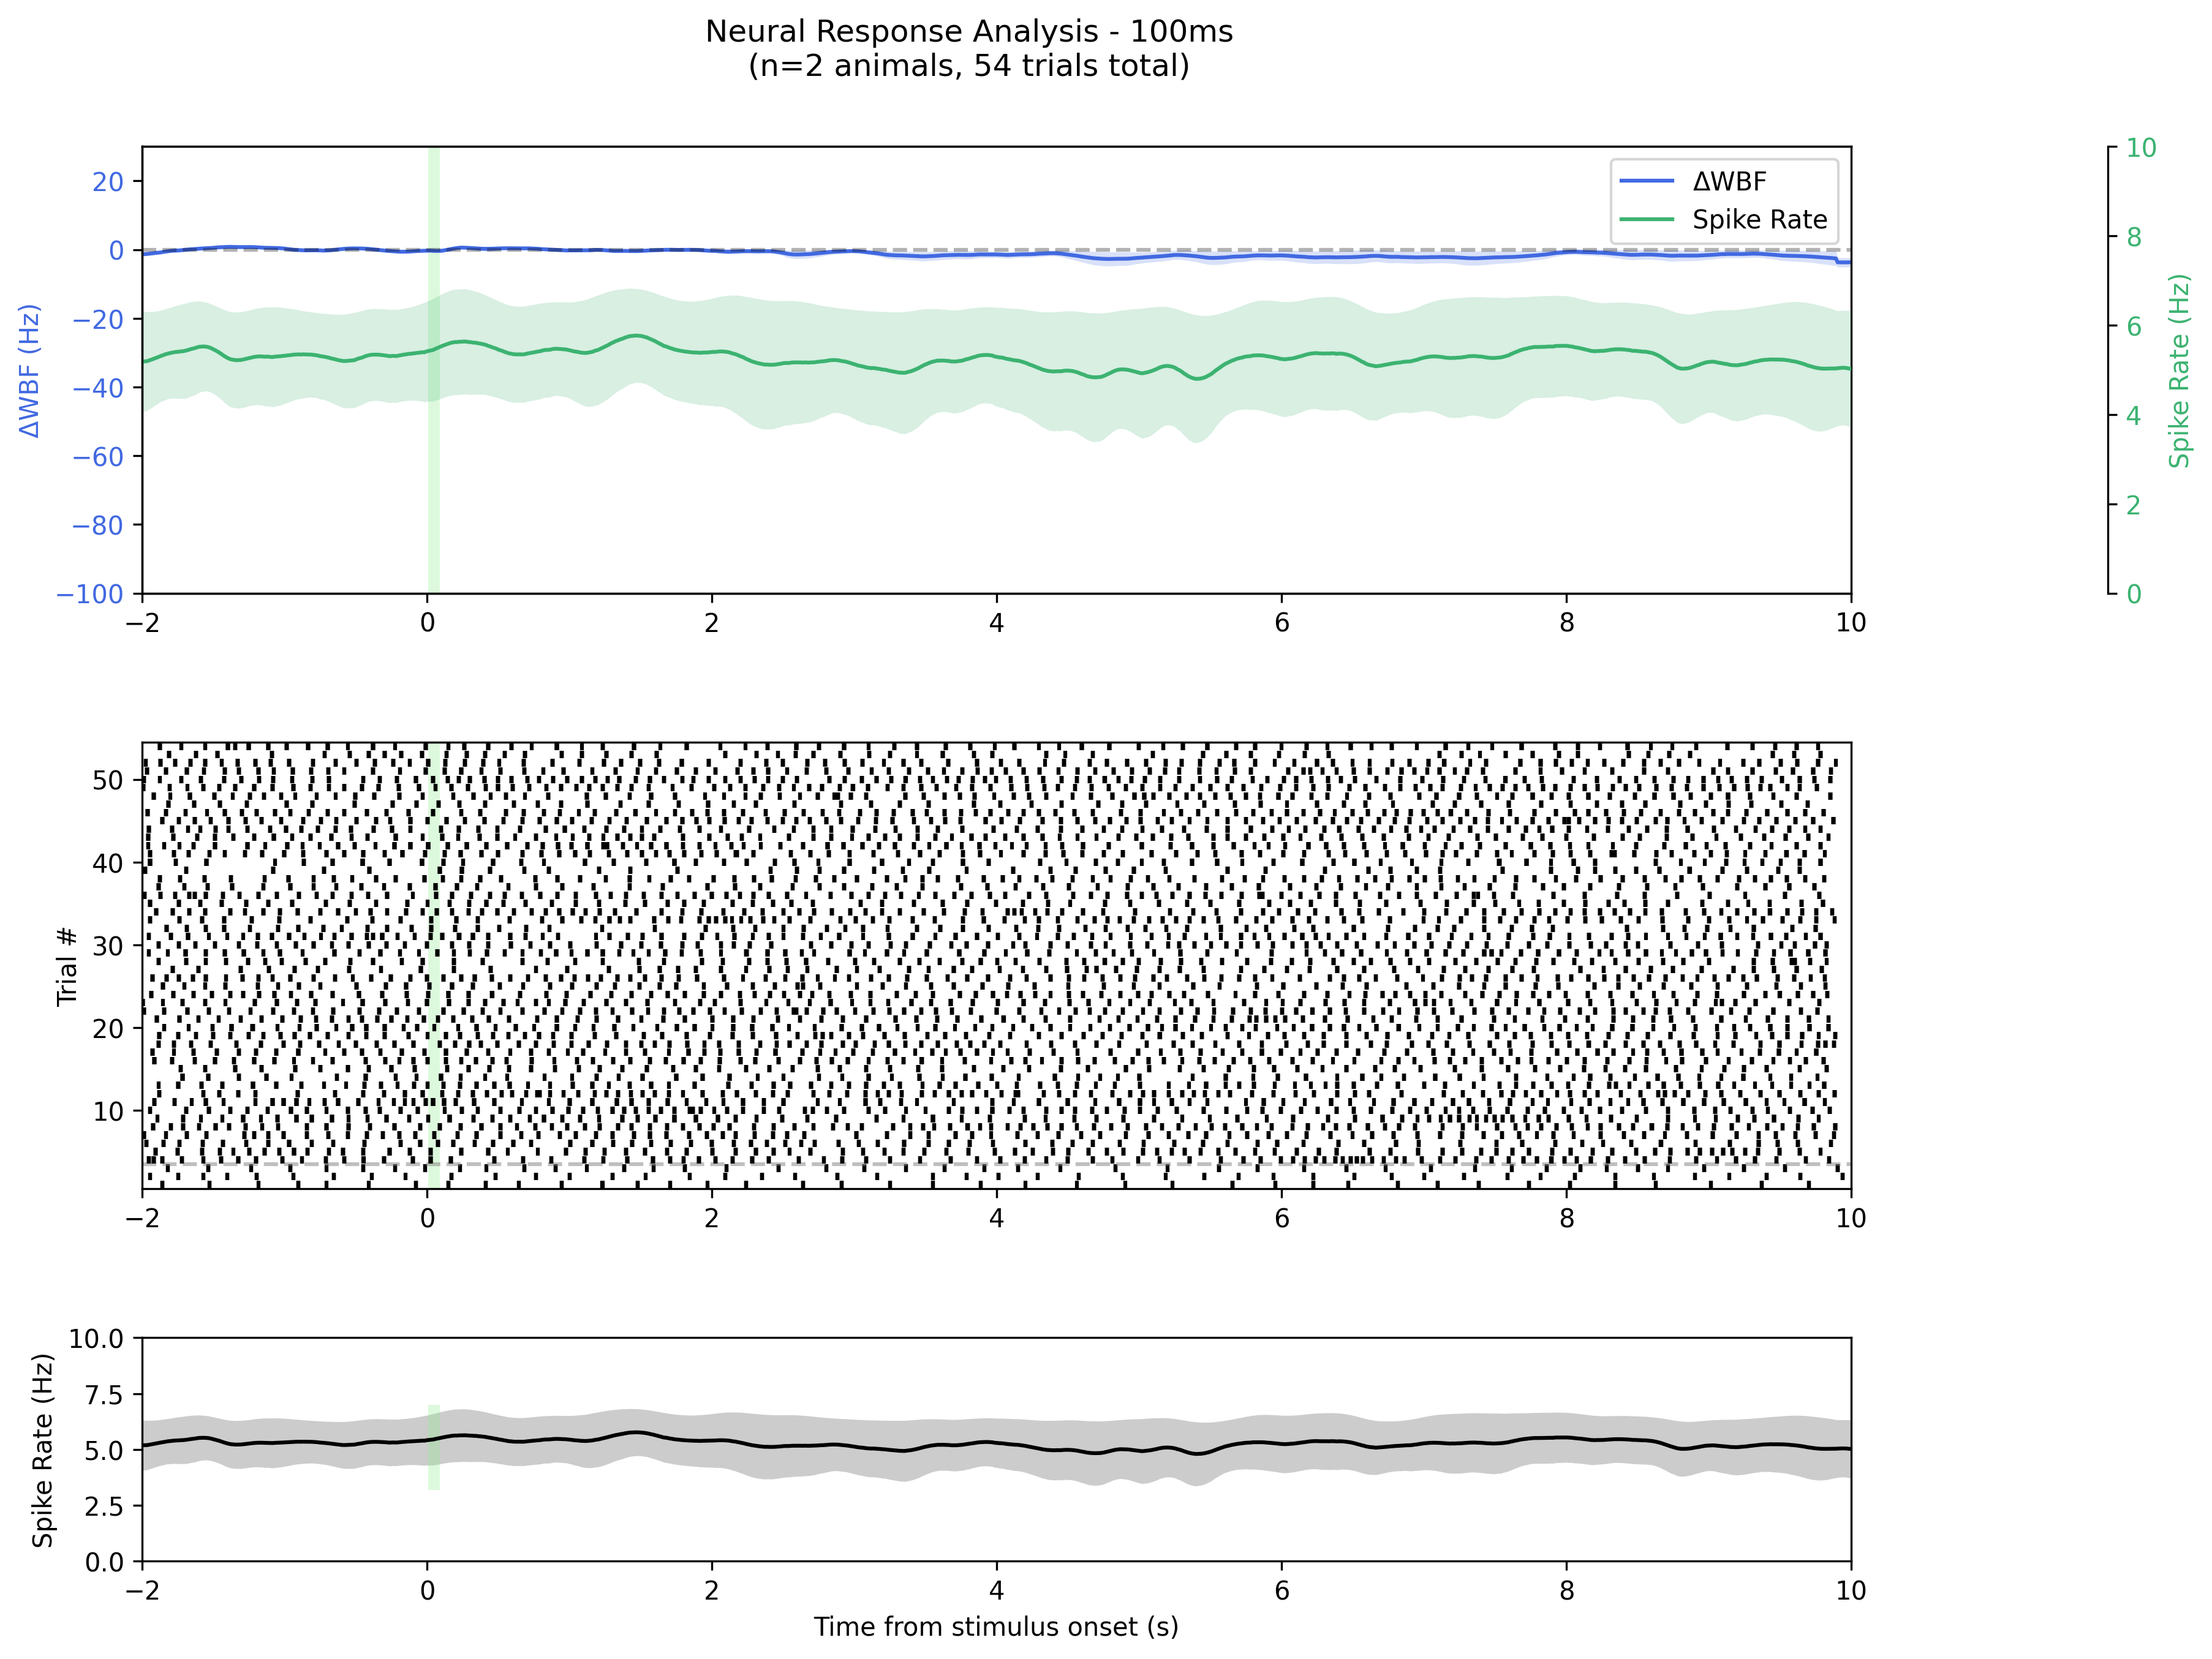


Processing 300ms (found in 2 animals)


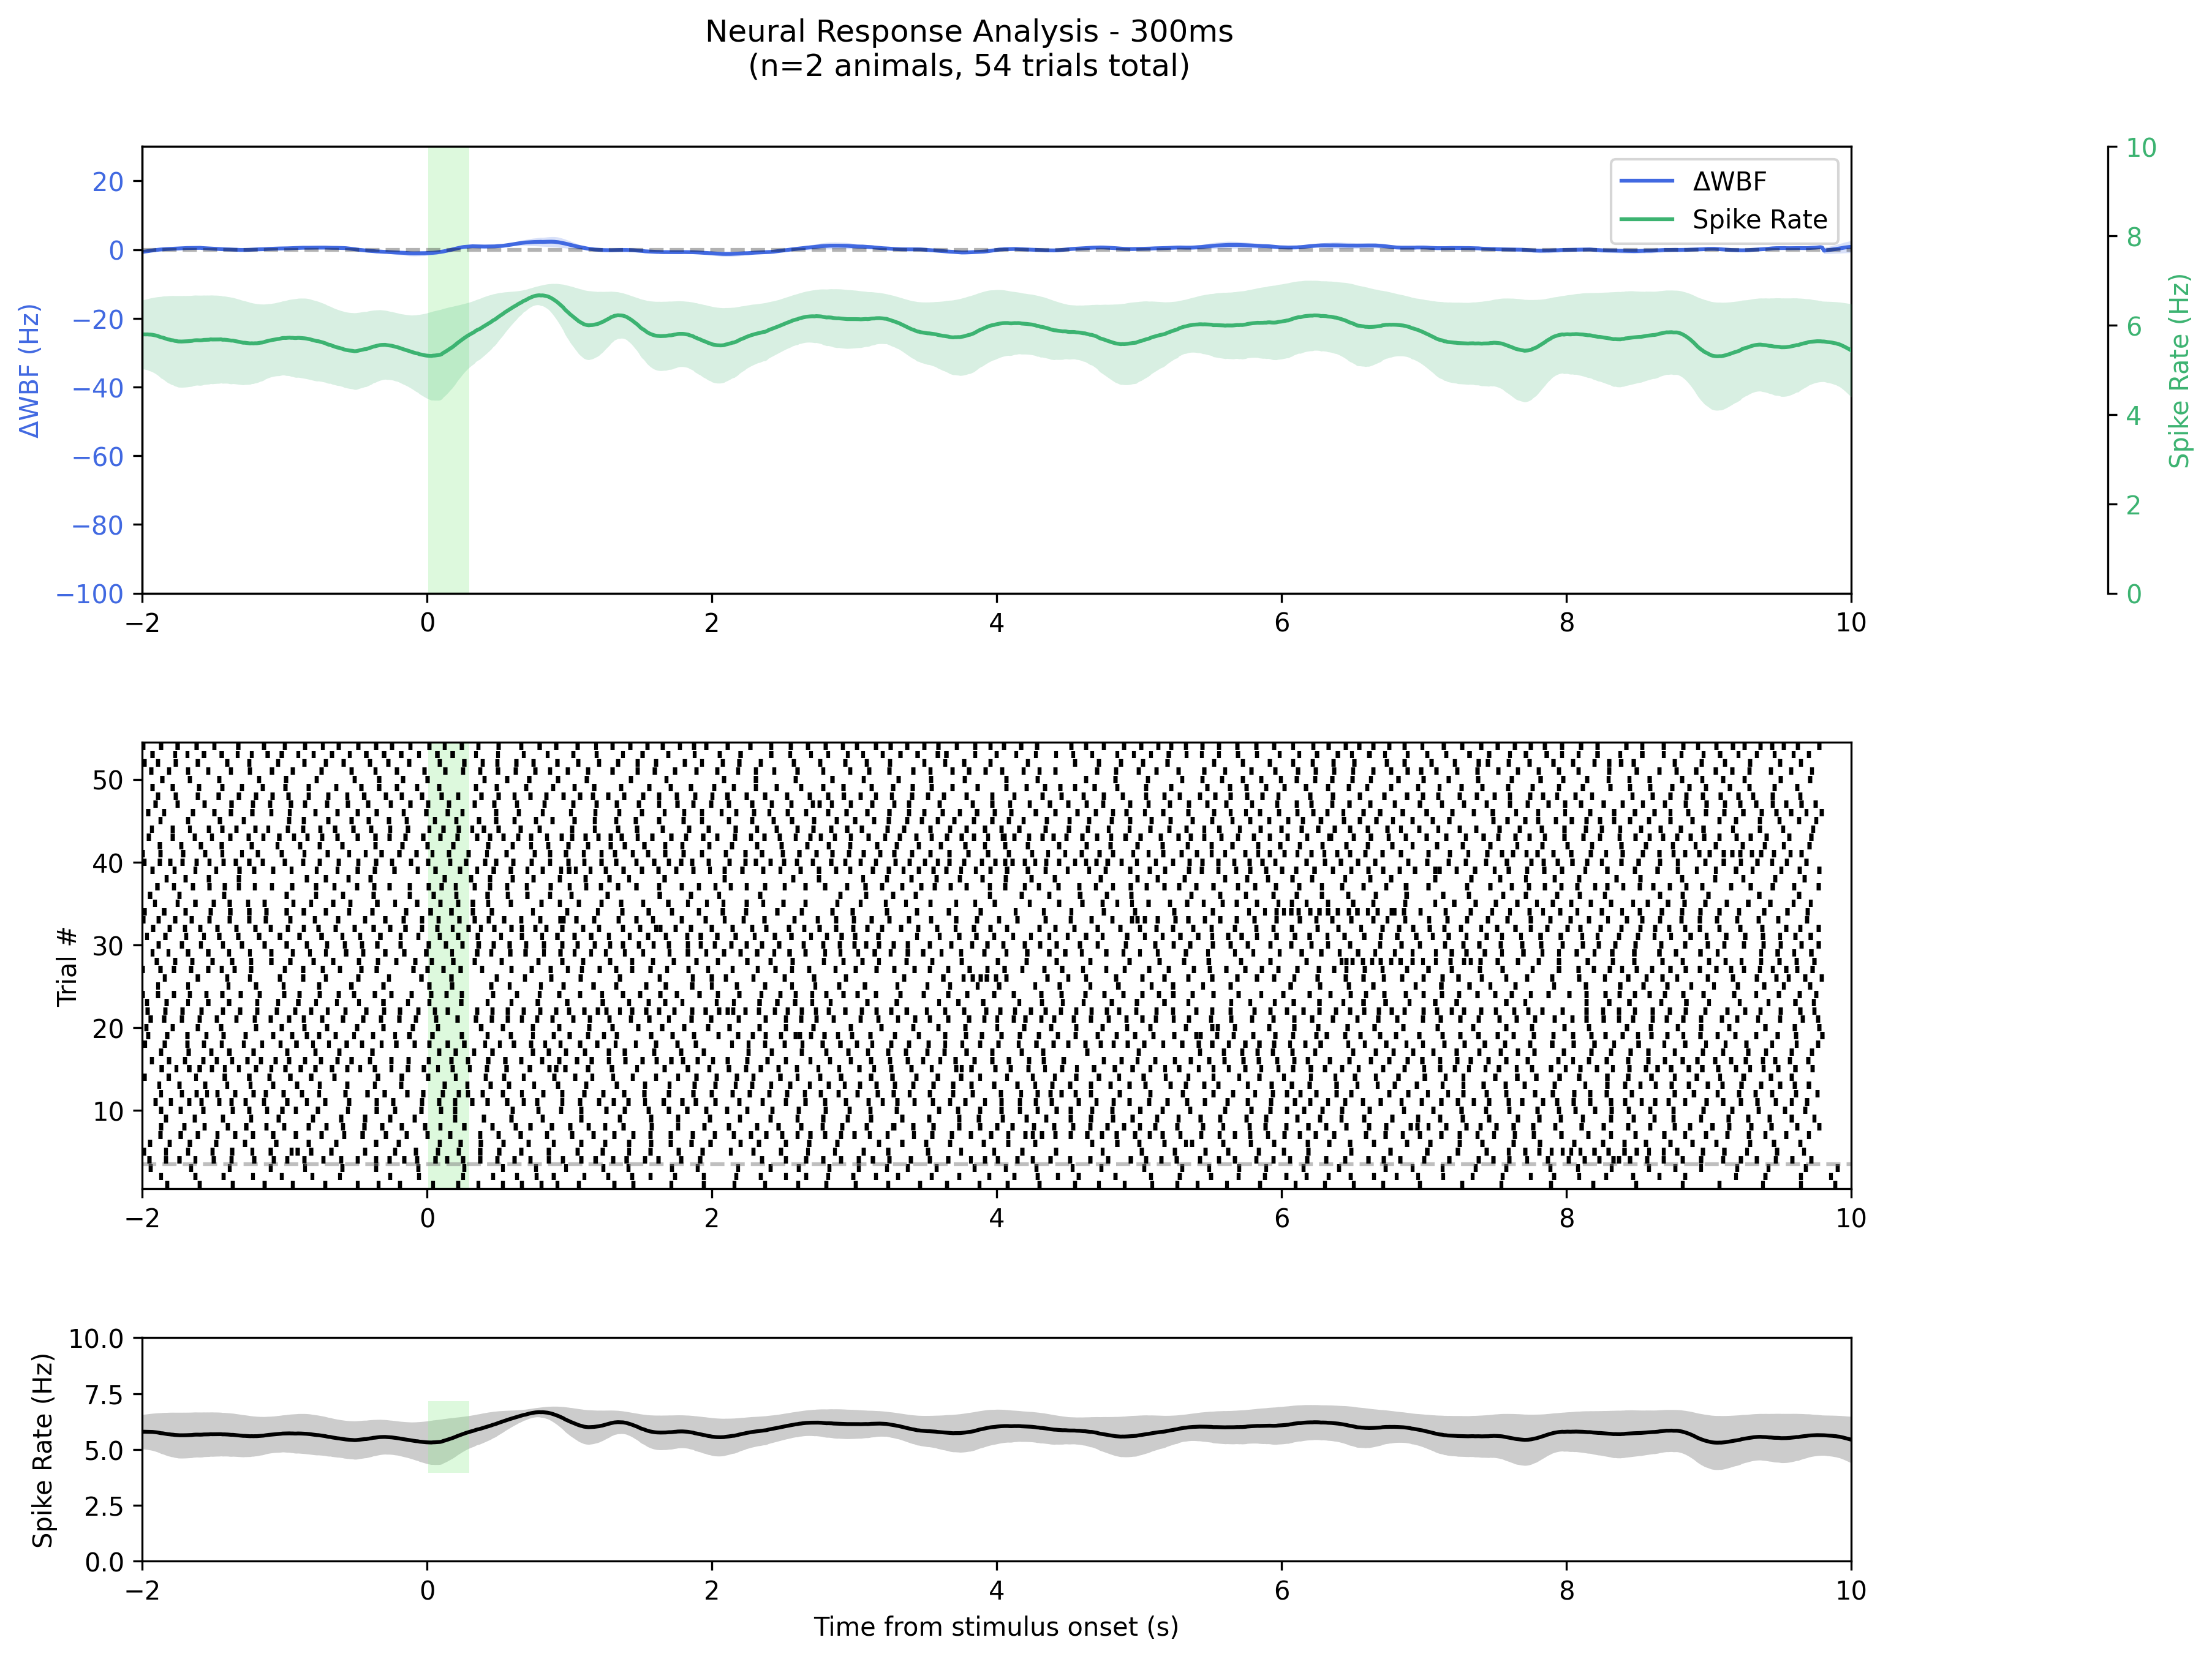


Processing 1000ms (found in 2 animals)


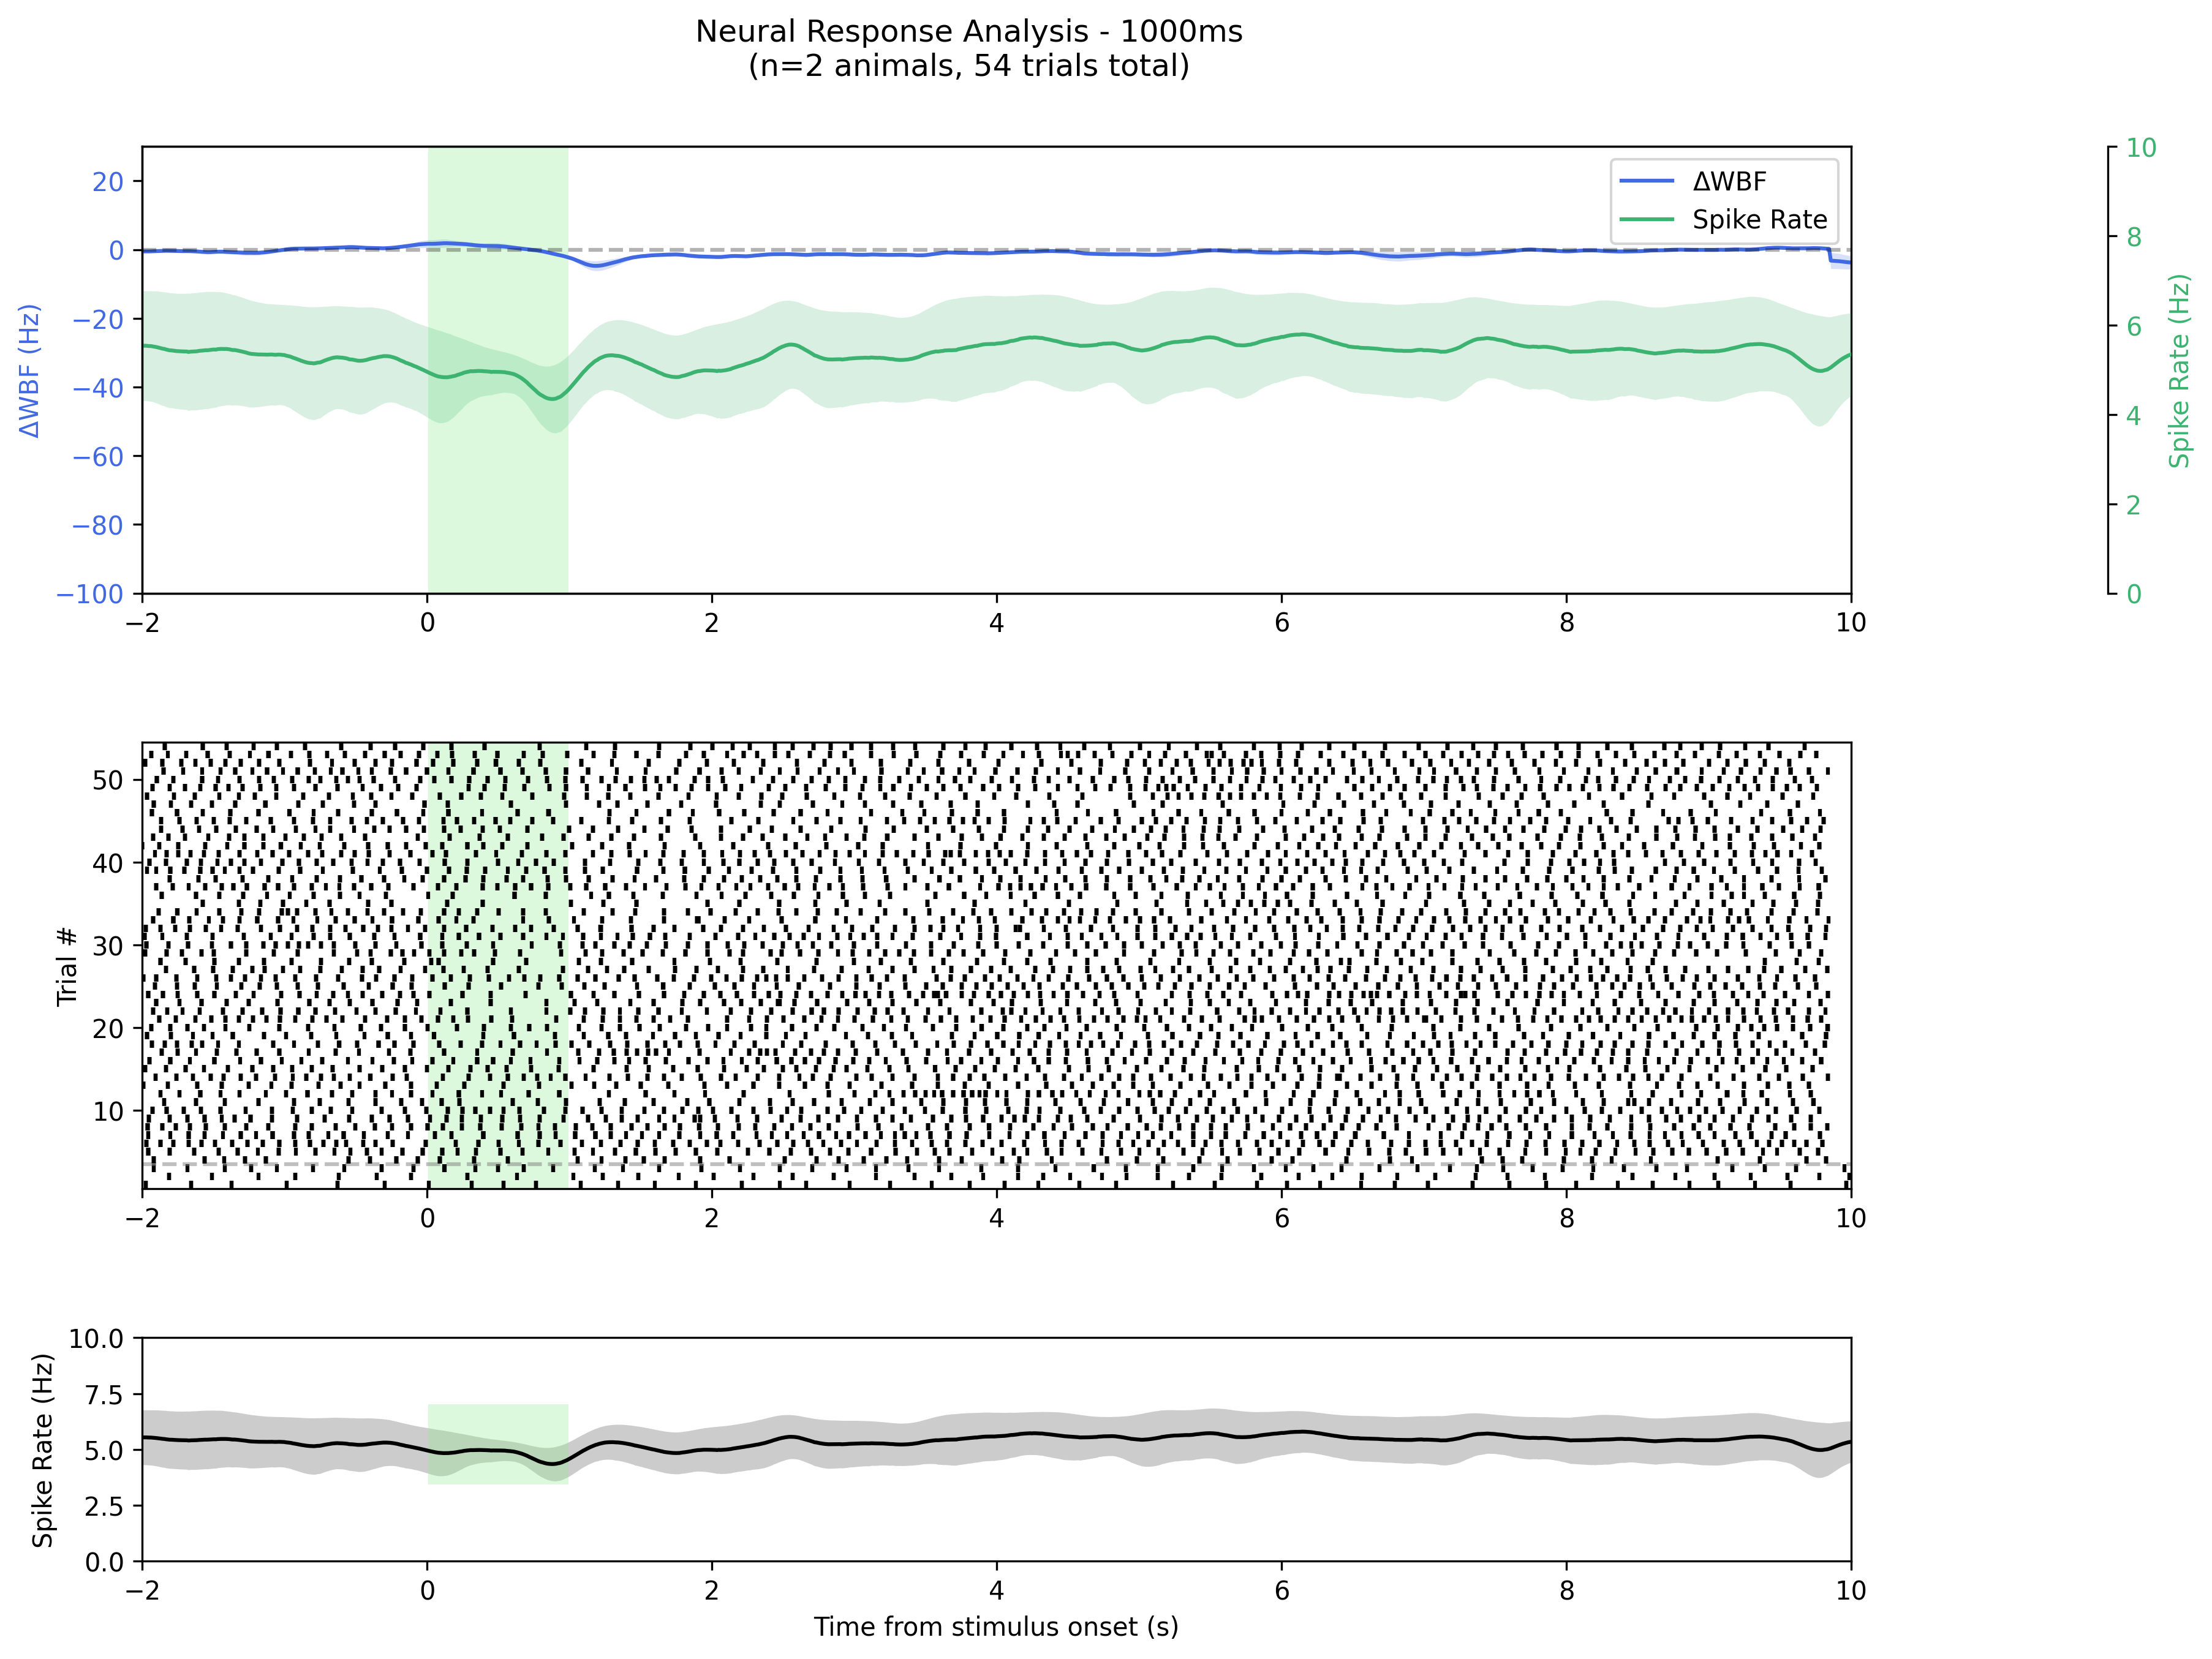


Processing 3000ms (found in 7 animals)


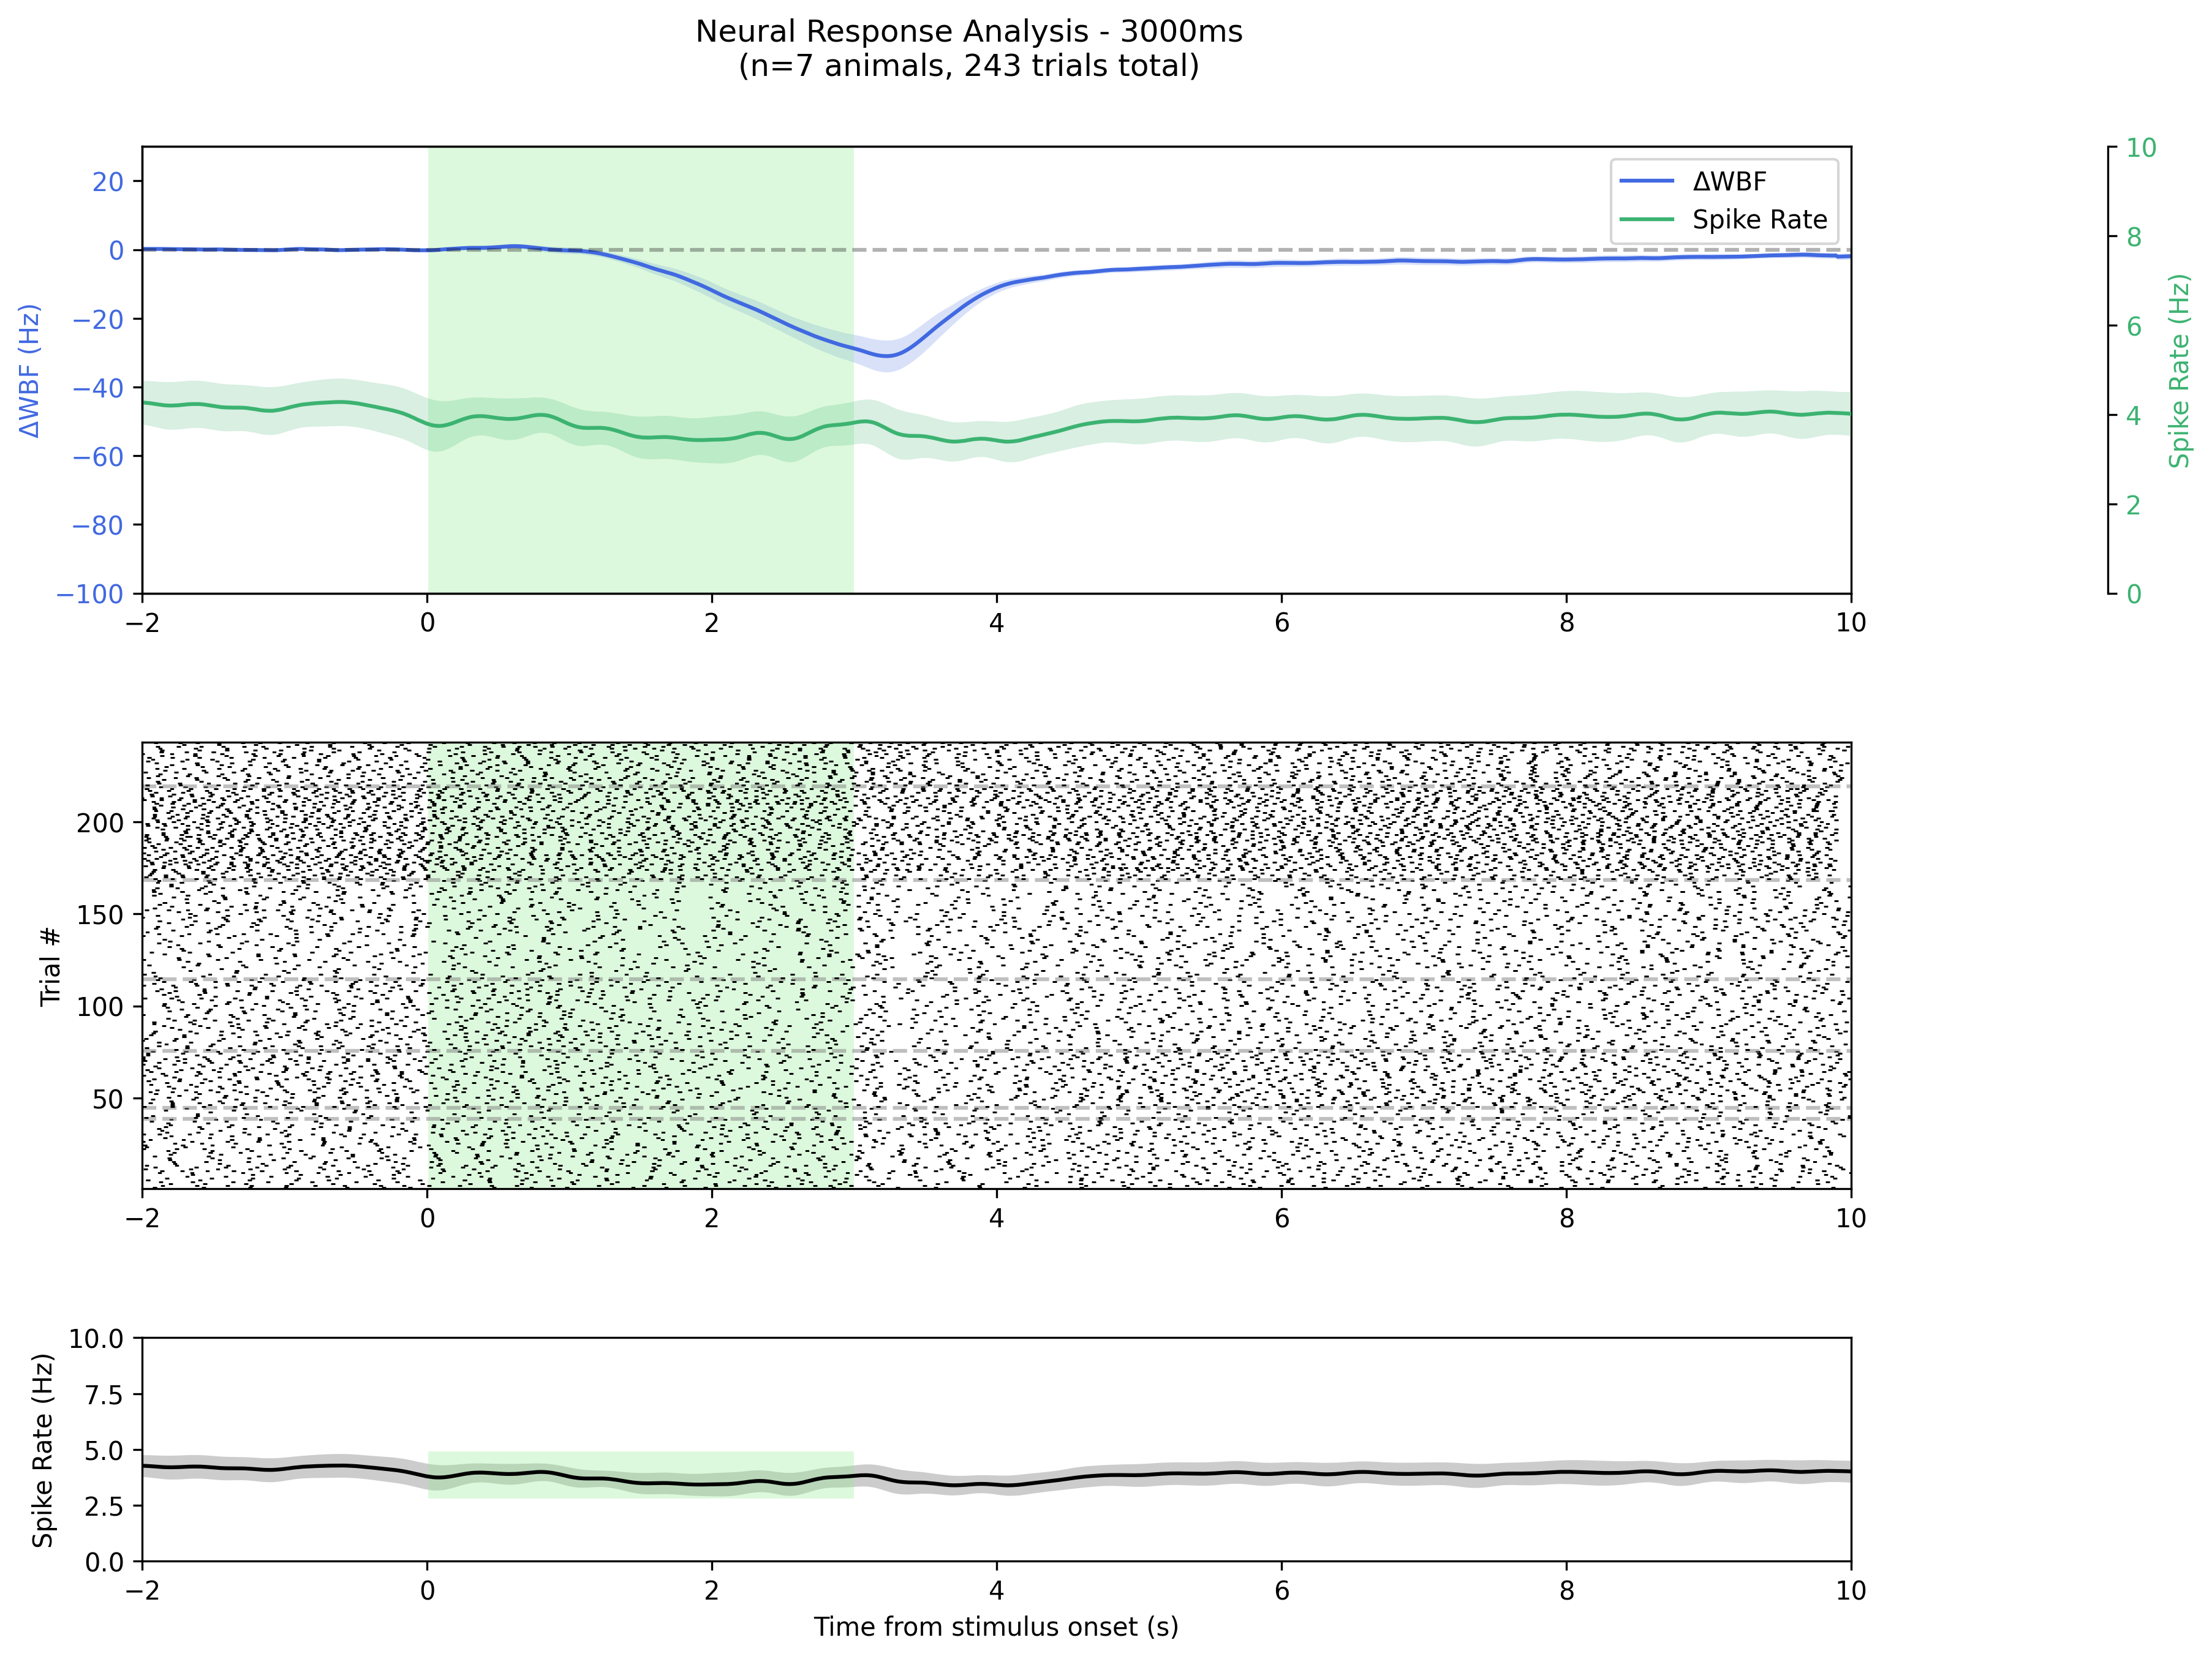


Processing 10000ms (found in 4 animals)


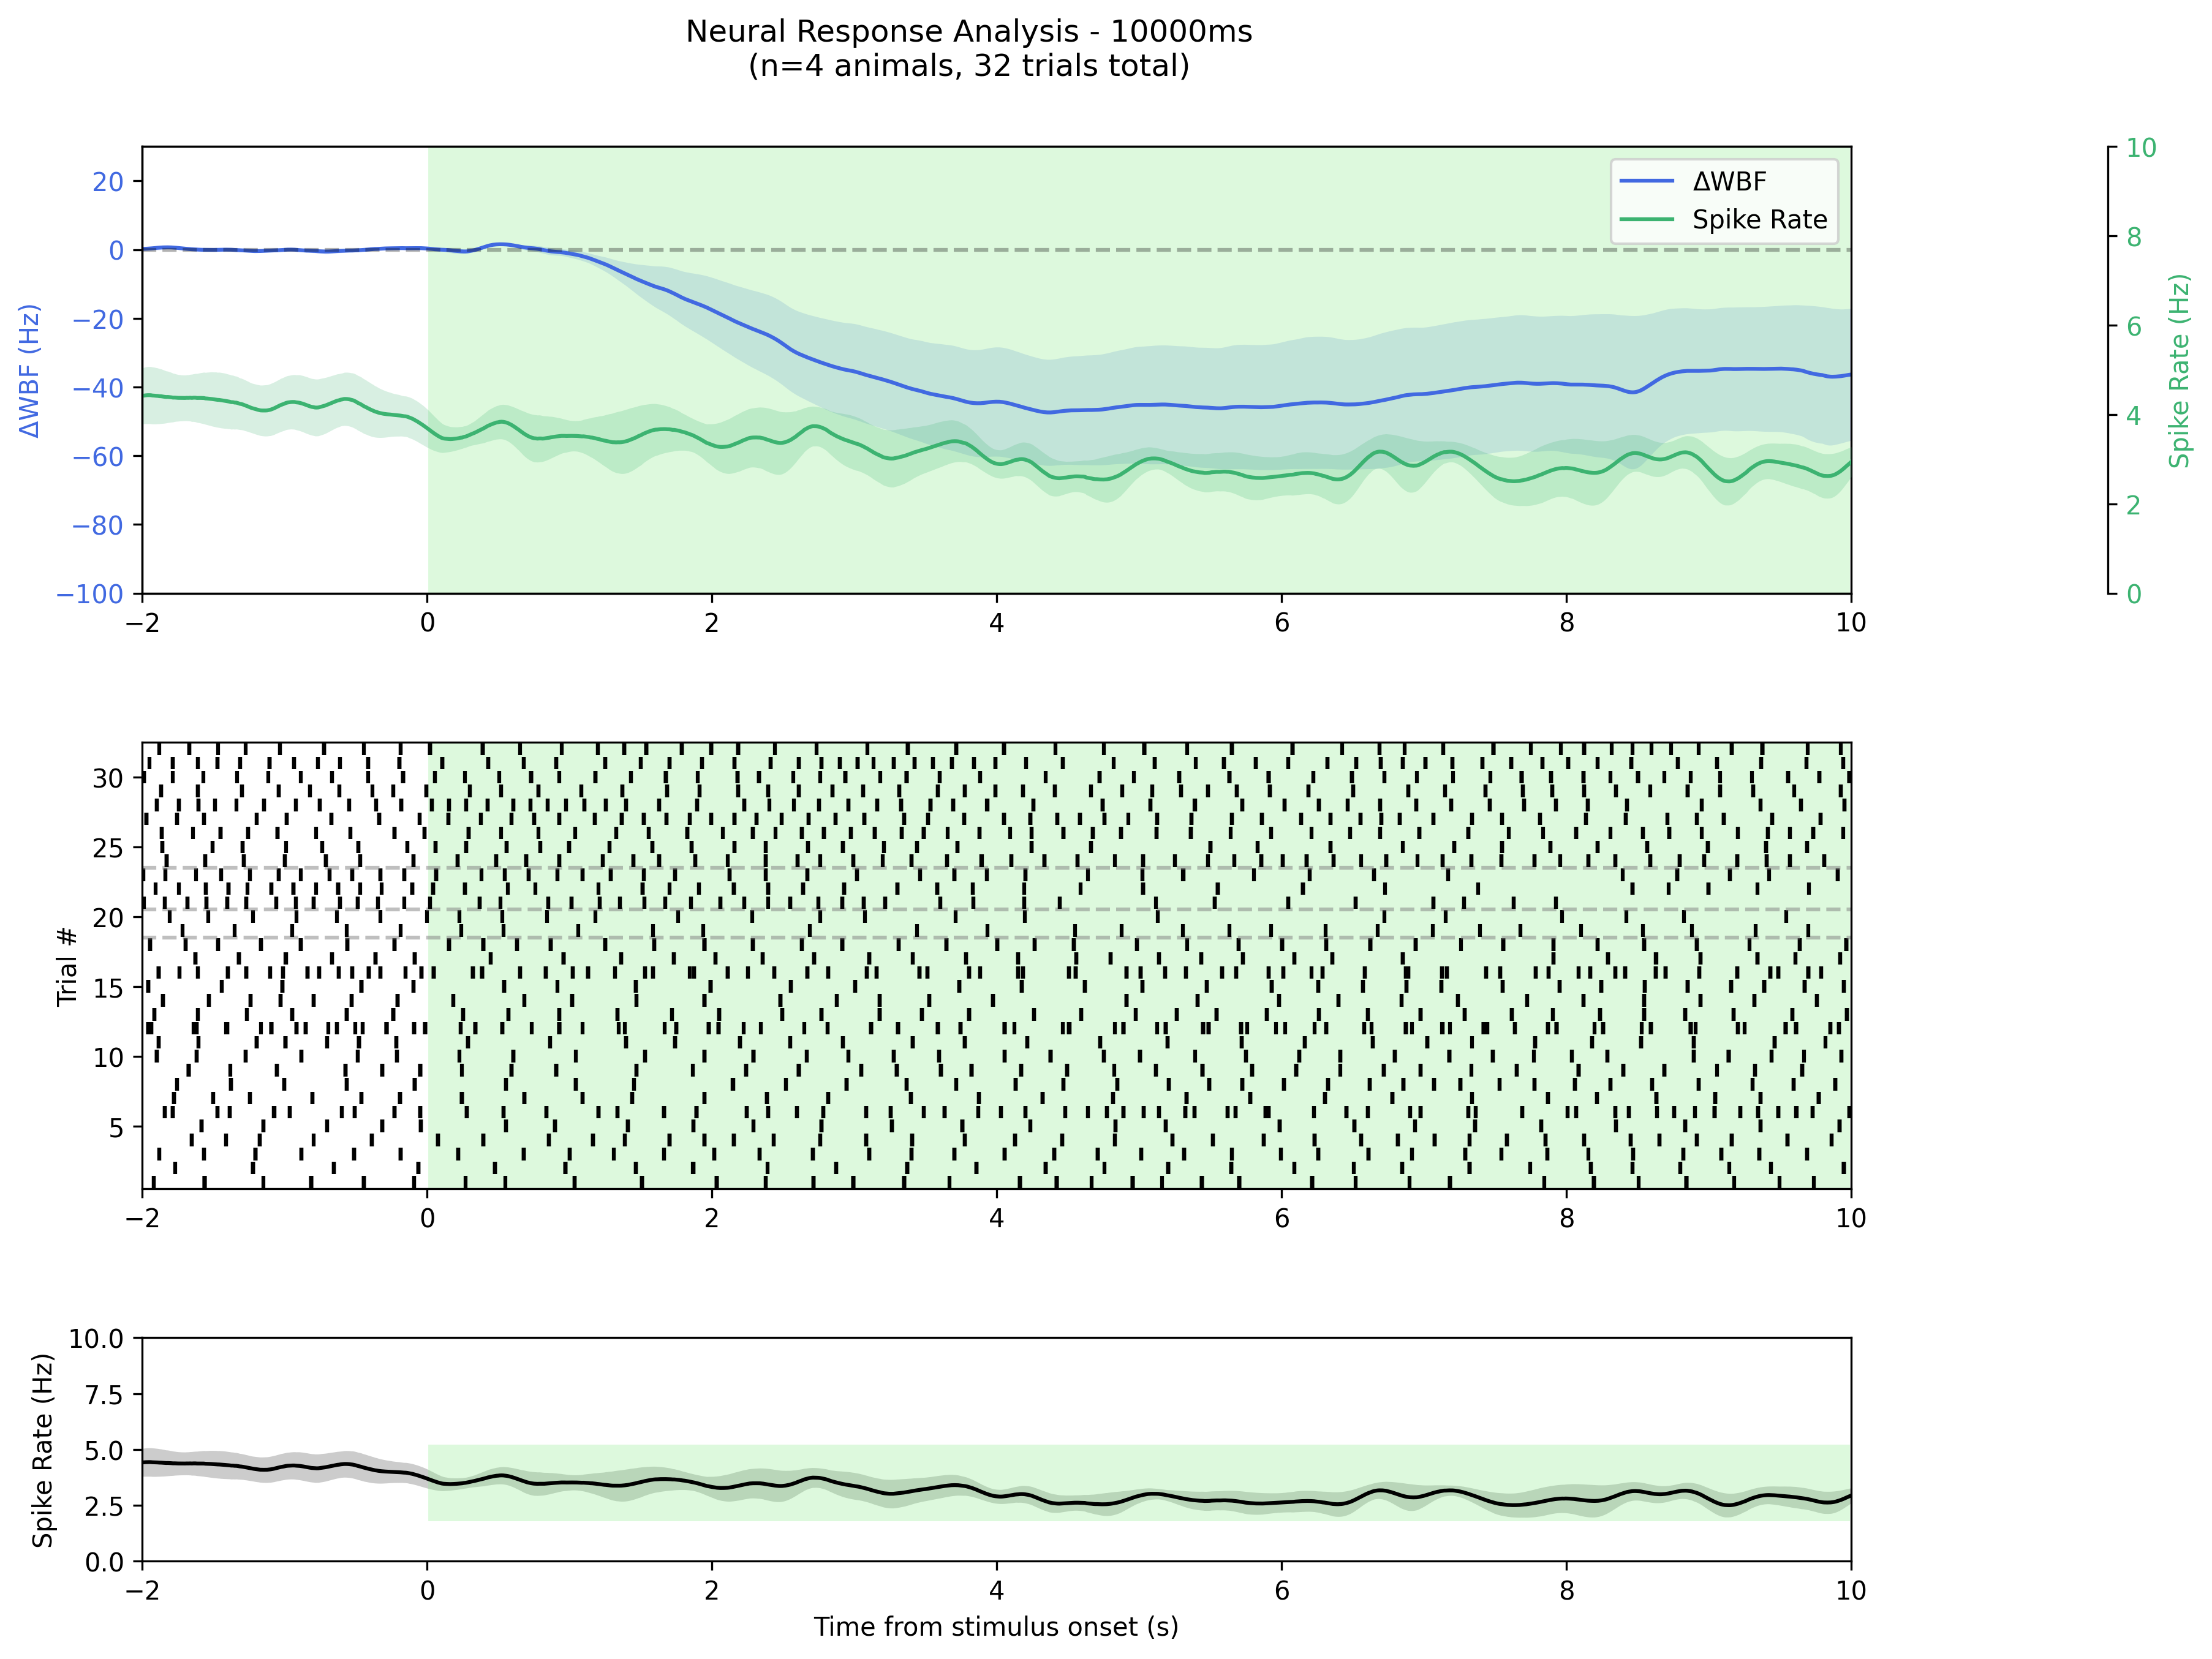

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

# Main directory containing all fly folders
main_directory = '/Users/camellyc/Library/CloudStorage/GoogleDrive-yichen@tuthill.casa/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Yichen/Spiracle/Spiracle Imaging/EMG_Analysis/1_spMN_ChR'
main_path = Path(main_directory)

def plot_cross_animal_summary(stim_files: list, time_window=(-2, 10), save_fig=True) -> None:
    """
    Create summary plot across animals for a given stimulus duration.
    """
    # Read and combine data from all animals
    all_dfs = []
    for file in stim_files:
        df = pd.read_csv(file)
        # Filter to time window
        mask = (df['Time (s)'] >= time_window[0]) & (df['Time (s)'] <= time_window[1])
        df_window = df[mask].copy()
        all_dfs.append(df_window)
    
    # Interpolate to common timebase
    time = np.linspace(time_window[0], time_window[1], 1000)
    interpolated_data = []
    
    for df in all_dfs:
        interp_df = pd.DataFrame()
        interp_df['Time (s)'] = time
        
        # Interpolate each column
        for col in df.columns:
            if col == 'Time (s)':
                continue
            if col.startswith('Spike Count'):
                # Use nearest neighbor for spike counts
                f = lambda x: np.interp(x, df['Time (s)'], df[col], left=0, right=0)
            else:
                # Use linear interpolation for continuous variables
                f = lambda x: np.interp(x, df['Time (s)'], df[col])
            interp_df[col] = f(time)
        
        interpolated_data.append(interp_df)
    
    # Calculate means and SEMs across animals
    combined_df = pd.DataFrame()
    combined_df['Time (s)'] = time
    
    # Calculate mean and SEM for continuous variables
    metrics = ['Mean Delta Wingbeat Frequency', 'Mean Spike Rate']
    for metric in metrics:
        values = np.array([df[metric] for df in interpolated_data])
        combined_df[metric] = np.mean(values, axis=0)
        combined_df[f'SEM {metric.split("Mean ")[-1]}'] = np.std(values, axis=0) / np.sqrt(len(values))
    
    # Use first animal's opto stimulus (they should be identical)
    combined_df['Opto Stimulus'] = interpolated_data[0]['Opto Stimulus']
    
    # Create figure
    fig = plt.figure(figsize=(12, 10), dpi=300)
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 2, 1], hspace=0.4)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    
    # First subplot
    ax1.grid(False)
    
    # WBF on left axis (blue)
    ax1.plot(time, combined_df['Mean Delta Wingbeat Frequency'], 
            color='royalblue', label='ΔWBF')
    ax1.fill_between(time,
                    combined_df['Mean Delta Wingbeat Frequency'] - combined_df['SEM Delta Wingbeat Frequency'],
                    combined_df['Mean Delta Wingbeat Frequency'] + combined_df['SEM Delta Wingbeat Frequency'],
                    color='royalblue', alpha=0.2,
                    linewidth=0)
    ax1.set_ylabel('ΔWBF (Hz)', color='royalblue')
    ax1.tick_params(axis='y', labelcolor='royalblue')
    ax1.set_ylim(-100, 30)
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # Spike Rate on second twin axis (green)
    ax1_spike = ax1.twinx()
    ax1_spike.grid(False)
    ax1_spike.spines["right"].set_position(("axes", 1.15))
    ax1_spike.plot(time, combined_df['Mean Spike Rate'], 
                  color='mediumseagreen', label='Spike Rate')
    ax1_spike.fill_between(time,
                          combined_df['Mean Spike Rate'] - combined_df['SEM Spike Rate'],
                          combined_df['Mean Spike Rate'] + combined_df['SEM Spike Rate'],
                          color='mediumseagreen', alpha=0.2,
                          linewidth=0)
    ax1_spike.set_ylabel('Spike Rate (Hz)', color='mediumseagreen')
    ax1_spike.tick_params(axis='y', labelcolor='mediumseagreen')
    ax1_spike.set_ylim(0, 10)
    
    # Add stimulus shading
    ymin, ymax = ax1.get_ylim()
    ax1.fill_between(time, ymin, ymax,
                    where=combined_df['Opto Stimulus'] > 0,
                    color='lightgreen', alpha=0.3,
                    linewidth=0)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines3, labels3 = ax1_spike.get_legend_handles_labels()
    ax1.legend(lines1 + lines3, 
              labels1 + labels3, 
              loc='upper right')
    
    # Second subplot: Spike raster with animal separators
    ax2.grid(False)
    current_trial = 0
    
    for animal_idx, df in enumerate(all_dfs):
        spike_columns = [col for col in df.columns if 'Spike Count Trial' in col]
        
        for col in spike_columns:
            spikes = df[col].values
            spike_diff = np.diff(spikes)
            spike_indices = np.where(spike_diff > 0)[0]
            spike_times = df['Time (s)'].values[spike_indices]
            
            current_trial += 1
            ax2.eventplot(spike_times, 
                         lineoffsets=current_trial,
                         linelengths=0.9,
                         color='black')
        
        # Add separator line between animals
        if animal_idx < len(all_dfs) - 1:
            ax2.axhline(y=current_trial + 0.5, color='gray', 
                       linestyle='--', alpha=0.5)
    
    # Add stimulus shading to raster
    ax2.fill_between(time, 0, current_trial + 1,
                    where=combined_df['Opto Stimulus'] > 0,
                    color='lightgreen', alpha=0.3,
                    linewidth=0)
    
    ax2.set_ylim(0.5, current_trial + 0.5)
    ax2.set_ylabel('Trial #')
    
    # Third subplot: Average spike rate
    ax3.grid(False)
    ax3.plot(time, combined_df['Mean Spike Rate'], color='black')
    ax3.fill_between(time,
                    combined_df['Mean Spike Rate'] - combined_df['SEM Spike Rate'],
                    combined_df['Mean Spike Rate'] + combined_df['SEM Spike Rate'],
                    color='black', alpha=0.2,
                    linewidth=0)
    
    ax3.fill_between(time, ax3.get_ylim()[0], ax3.get_ylim()[1],
                    where=combined_df['Opto Stimulus'] > 0,
                    color='lightgreen', alpha=0.3,
                    linewidth=0)
    
    ax3.set_ylim(0, 10)
    ax3.set_ylabel('Spike Rate (Hz)')
    ax3.set_xlabel('Time from stimulus onset (s)')
    
    # Set x-axis limits for all subplots
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(time_window)
    
    # Get stimulus duration from first file name
    stim_duration = stim_files[0].stem.split('_')[1]
    n_animals = len(all_dfs)
    n_trials = current_trial
    
    # Add title
    fig.suptitle(f"Neural Response Analysis - {stim_duration}\n(n={n_animals} animals, {n_trials} trials total)", 
                y=0.95)
    
    if save_fig:
    # Save as both PNG and SVG
        output_path_svg = main_path / f'summary_across_animals_{stim_duration}.svg'
        plt.savefig(output_path_svg, format='svg', bbox_inches='tight')
    
    plt.show()

# Find all fly folders
fly_folders = [f for f in main_path.iterdir() if f.is_dir() and 'Fly' in f.name]
print(f"Found {len(fly_folders)} fly folders")

# Collect all summary files by stimulus duration
summary_by_duration = {}
for fly_folder in fly_folders:
    summary_files = list(fly_folder.glob('summary_*ms.csv'))
    for file_path in summary_files:
        stim_duration = file_path.stem.split('_')[1]
        if stim_duration not in summary_by_duration:
            summary_by_duration[stim_duration] = []
        summary_by_duration[stim_duration].append(file_path)

# Sort stimulus durations numerically
stim_durations = sorted(summary_by_duration.keys(), 
                       key=lambda x: int(x.rstrip('ms')))

# Process each stimulus duration
for stim_duration in stim_durations:
    files = summary_by_duration[stim_duration]
    print(f"\nProcessing {stim_duration} (found in {len(files)} animals)")
    plot_cross_animal_summary(files, time_window=(-2, 10))